# CITS5508 Assignment1 

Amy HUNG (23702699)

# Part 1 - Classification

In Part I of this assignment, the dataset analysed is modified from the Forest type mapping dataset, which can be obtained from the UCI Machine Learning website (http://archive.ics.uci.edu/ml/datasets/Forest+type+mapping#). 

The dataset contains data on different forests' spectral characteristics at visible-to-near infrared wavelengths, using ASTER satellite imagery and mapping into 4 forest types - (i) 'Sugi' forest, (ii) 'Hinoki' forest, (iii) 'Mixed deciduous' forest and (iv) 'Other' non-forest land. Based on the forest type mapping, the ecosystem services (e.g. carbon storage, erosion protection) provided by the forest can be identified and/or quantified.

Since the dataset analysed contains labelled data (forest type mapping), we aim to perform binary and multiclass classifications by different supervised machine learning algorithms, such as (i) Logistic Regression Classifier, (ii) k-nearest neighbours Classifier, (iii) Support Vector Machine Classifier and (iv) Softmax Regression, to predict the forest types in this part. The dataset analysed covers in total 523 observations.

## 1.1 Data loading, overview and set up

### 1.1.1 Loading all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils import class_weight

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 1.1.2 Loading the dataset in the Jupyter Notebook

In [3]:
forest_train = pd.read_csv("training.csv")
forest_test = pd.read_csv("testing.csv")

### 1.1.3 Quick overview on the dataset

According to the machine learning project framework, we have to understand the data first. Although for the purpose of this project in the first place, we have divided the dataset into 2 files - training (325 instances) and testing (198 instances), we combined both training and test files in this data exploration section to obtain overall understanding on the dataset. 

In [4]:
# Combining both training and testing file for data exploration
forest_all = [forest_train, forest_test]
forest_all = pd.concat(forest_all)

# Checking the dimensions of the overall dataset
print('Number of rows:', forest_all.shape[0])
print('Number of columns:', forest_all.shape[1])

# Quick overview on the first 10 instances using head()
forest_all.head(10)

Number of rows: 523
Number of columns: 28


,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,67,51,68,115,69,111,136,31,67,...,-9.17,-18.27,-1.80,-6.32,-20.88,-1.63,-6.13,-22.56,-5.53,-8.11
1,s,67,28,51,99,50,97,82,26,59,...,-2.25,-20.13,-2.11,-6.35,-21.94,-1.22,-6.13,-22.20,-3.41,-6.57
2,s,63,26,50,95,49,91,81,26,57,...,-0.44,-17.64,-1.81,-4.70,-19.39,-0.65,-5.01,-20.89,-3.96,-6.85
3,d,63,42,63,97,66,108,111,28,59,...,-2.34,-20.20,-1.89,-5.47,-21.65,-0.99,-5.71,-22.19,-3.41,-6.52
4,s,46,27,50,83,51,90,76,26,56,...,1.25,-18.62,-2.17,-7.11,-21.12,-1.56,-6.35,-22.19,-4.45,-7.32
5,d,59,59,84,93,70,104,92,29,58,...,0.23,-17.16,-1.98,-6.48,-20.86,-1.79,-6.25,-23.44,-6.50,-8.93
6,h,83,28,54,117,51,96,105,27,64,...,-9.18,-26.14,-1.87,-5.87,-34.63,-1.83,-7.97,-29.34,-2.00,-5.03
7,o,63,37,58,95,58,101,89,27,62,...,-5.46,-21.14,-1.74,-4.98,-22.20,-0.93,-5.59,-22.39,-3.26,-6.37
8,s,77,29,52,103,51,93,87,27,59,...,-1.07,-16.86,-2.31,-6.72,-20.25,-1.77,-6.29,-23.00,-6.11,-8.57
9,d,57,44,65,107,59,104,98,26,59,...,-2.38,-20.40,-2.18,-6.74,-21.67,-1.21,-6.24,-21.76,-3.06,-6.32


By looking at the dimension of the dataset, we can see that there are in total 523 instances and 28 columns (forest type mapping and 27 attributes). 

From the first glance on the first 10 rows, these 27 attributes can be categorised into 4 main types:

- class: Types of forest - (i) 'Sugi' forest ('s'), (ii) 'Hinoki' forest ('h'), (iii) 'Mixed deciduous' forest ('d') and (iv) 'Other' non-forest land ('o') <br>
- b1 - b9: ASTER image bands containing spectral information in the green, red, and near infrared wavelengths for three dates <br>
- pred_minus_obs_S_b1 - pred_minus_obs_S_b9: Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 's' class (b1-b9) <br>
- pred_minus_obs_H_b1 - pred_minus_obs_H_b9: Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 'h' class (b1-b9)

In [5]:
# Further look at the description of data using info()
forest_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523 entries, 0 to 197
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   class                523 non-null    object 
 1   b1                   523 non-null    int64  
 2   b2                   523 non-null    int64  
 3   b3                   523 non-null    int64  
 4   b4                   523 non-null    int64  
 5   b5                   523 non-null    int64  
 6   b6                   523 non-null    int64  
 7   b7                   523 non-null    int64  
 8   b8                   523 non-null    int64  
 9   b9                   523 non-null    int64  
 10  pred_minus_obs_H_b1  523 non-null    float64
 11  pred_minus_obs_H_b2  523 non-null    float64
 12  pred_minus_obs_H_b3  523 non-null    float64
 13  pred_minus_obs_H_b4  523 non-null    float64
 14  pred_minus_obs_H_b5  523 non-null    float64
 15  pred_minus_obs_H_b6  523 non-null    flo

From the above output, we can observe:

(i) types of variables
- 1 categorical variable : class;
- 9 numerical variables in the type of integer: b1 - b9; and
- 18 numerical variables in the type of floating numbers: all remaining attributes

(ii) there are no missing values for all the columns.

Though there are no null values noted in the dataset, we have to further investigate if there are any unreasonable inputs or outliers in the later stage, which may require further treatment in data preparation for classification. 

For the purpose of this project, we excluded all the columns whose name begin with "pred_minus_obs" for easier intepretation.

In [6]:
# Dropping columns being with "pred_minus_obs" in both training and testing files
forest_train_classi = forest_train

for col in forest_train_classi.columns:
    if 'pred_minus_obs' in col:
        del forest_train_classi[col]
  
forest_test_classi = forest_test

for col in forest_test_classi.columns:
    if 'pred_minus_obs' in col:
        del forest_test_classi[col]
        
# Combining both files again for data exploration
forest_combine = [forest_train_classi, forest_test_classi]
forest_combine = pd.concat(forest_combine)

forest_combine.head(10)

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,d,67,51,68,115,69,111,136,31,67
1,s,67,28,51,99,50,97,82,26,59
2,s,63,26,50,95,49,91,81,26,57
3,d,63,42,63,97,66,108,111,28,59
4,s,46,27,50,83,51,90,76,26,56
5,d,59,59,84,93,70,104,92,29,58
6,h,83,28,54,117,51,96,105,27,64
7,o,63,37,58,95,58,101,89,27,62
8,s,77,29,52,103,51,93,87,27,59
9,d,57,44,65,107,59,104,98,26,59


### 1.1.4 Data Visualisation

From the above overview, we noted there are both categorical and numberical variables in the dataset. In this section, we investigated the numberical and categorical variables separately first.

#### 1.1.4.1 Numberical variables (b1 - b9)

In [7]:
# Looking at the descriptive statistics of each attribute
forest_combine.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9
count,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,59.887189,39.380497,62.304015,98.156788,58.338432,99.747610,87.657744,27.873805,59.726577
std,12.345004,15.930120,15.937658,12.881210,11.336637,10.151598,16.398751,8.076700,9.291151
min,31.000000,23.000000,47.000000,54.000000,43.000000,83.000000,42.000000,19.000000,45.000000
25%,51.500000,28.000000,52.000000,90.000000,50.000000,93.000000,76.000000,24.000000,54.500000
50%,58.000000,32.000000,56.000000,96.000000,55.000000,97.000000,88.000000,25.000000,57.000000
75%,67.000000,48.000000,67.000000,107.000000,64.000000,104.000000,99.000000,27.000000,60.000000
max,107.000000,160.000000,196.000000,172.000000,100.000000,138.000000,139.000000,84.000000,114.000000


From the above table, we can observe:

(i) Outliers: we can see the gaps between 75 percentile and max are relatively large on some attributes, such as b8 and b9. These may indicate the existance of outliers.

(ii) Different scales among features: the 9 attributes are observed to have different scales, such as the range of values in b6 is between 83 and 139, while that of b8 is between 19 and 84. 

To have a better overview and comparison on the distribution of these attributes, we then plot the following histograms and boxplots.

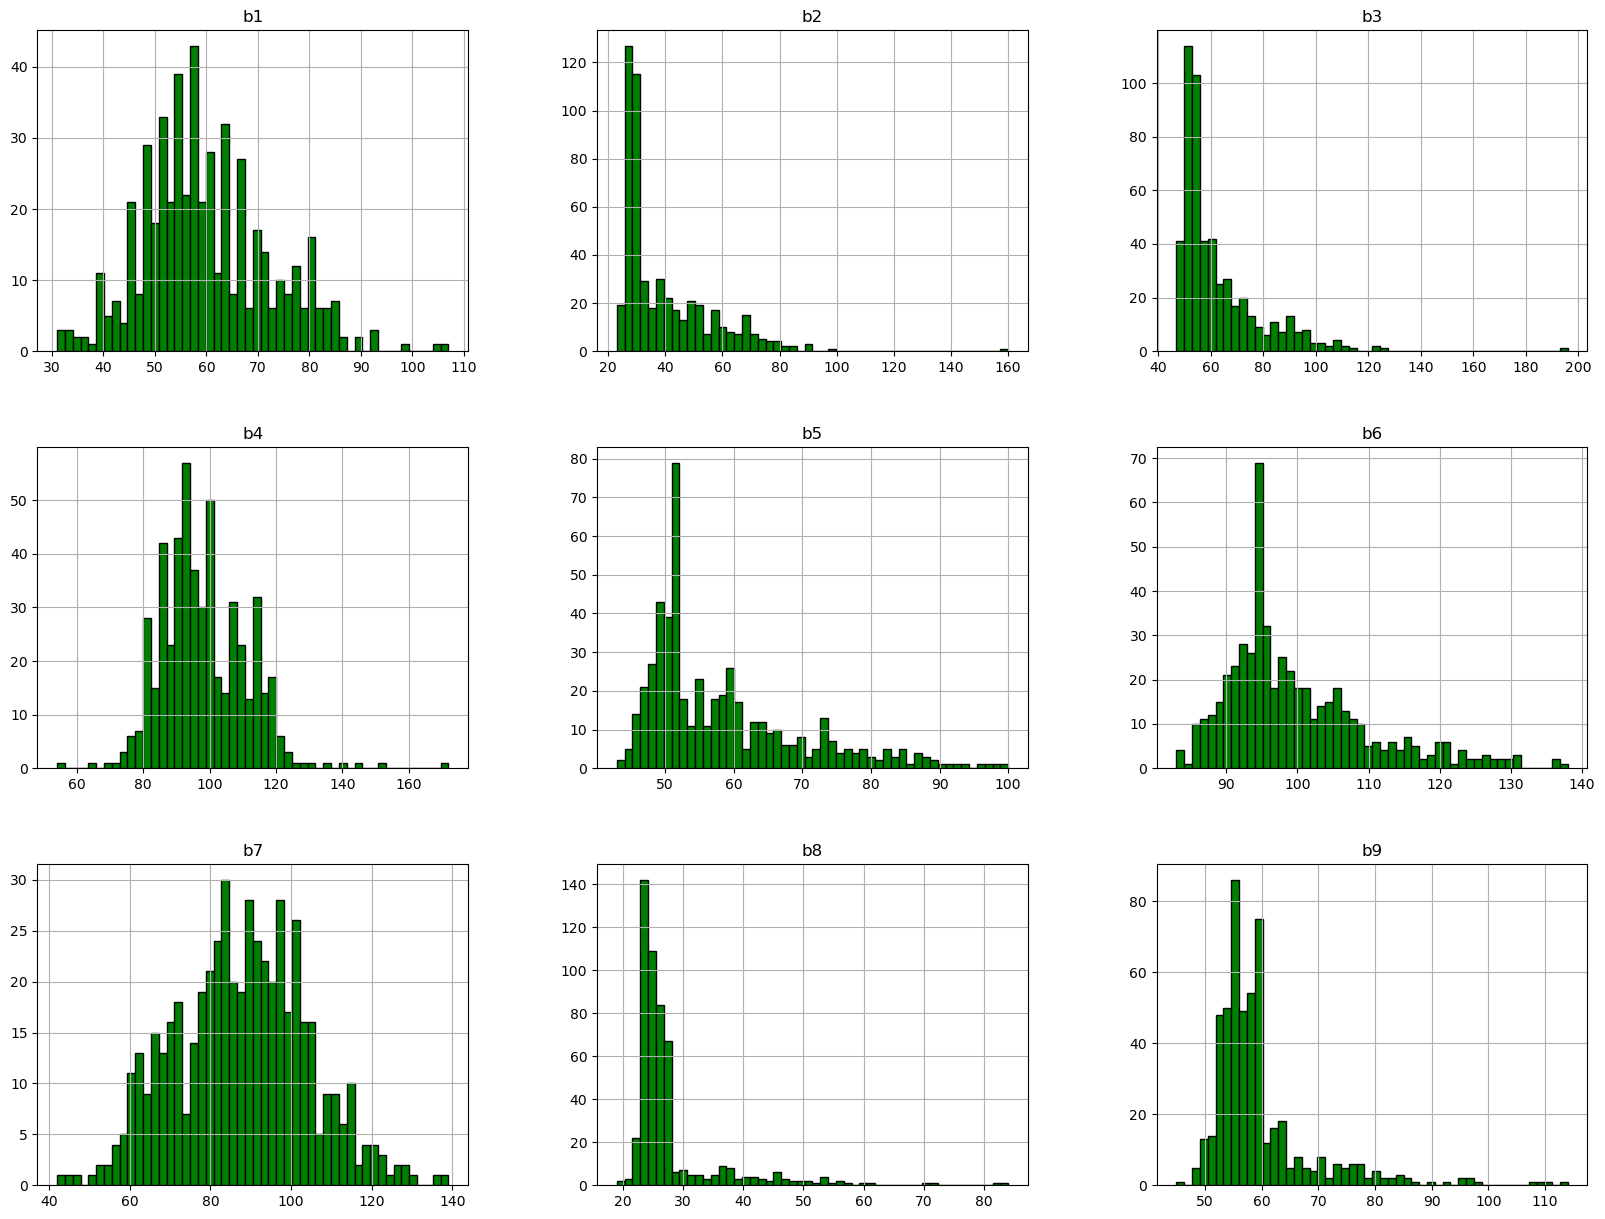

In [8]:
# Plotting histograms for every numberical variable
forest_combine.hist(bins=50, figsize=(20,15), color = "green", edgecolor = "black")
plt.show()

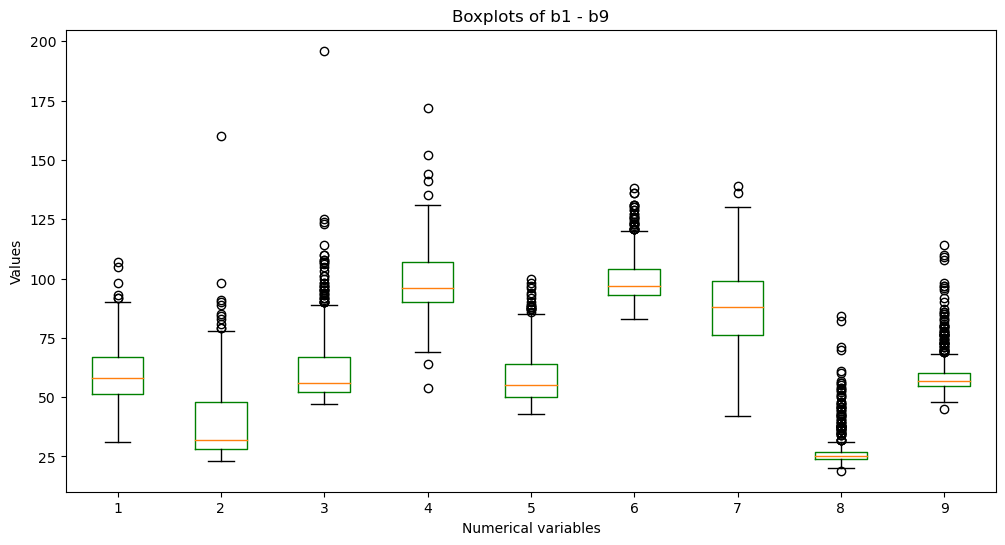

In [9]:
fig_box, ax_box = plt.subplots(figsize=(12, 6))
num_cols = ["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9"]

# Set the box properties, including the color
boxprops = dict(linestyle='-', linewidth=1, color='green')
ax_box.boxplot(forest_combine[num_cols], boxprops=boxprops)

ax_box.set_title("Boxplots of b1 - b9")
ax_box.set_xlabel("Numerical variables")
ax_box.set_ylabel("Values")
ax_box.grid(False)
plt.show()

From the above histograms and boxplots, we can see they are consistent to the findings from the previous descriptive statistics table. 

(i) Outliers:
The distribution of some of the attributes (b2, b3, b5, b6, b8 and b9) seem to be  quite right-skewed in histograms, which indicate there are some outliers with very large values (also shown in the boxplots). Certain transformation may have to perform to make these attributions to be normally distributed for further analysis. As for b1, b4 and b7, their distributions are approximately symmatric and normally distributed. Normalisation or standardisation may have to perform on these attributes. Apart from outliers, there are no unreasonable or invalid input noted in the dataset.

(ii) Different scales on the features:
By looking at the x-axis in the histograms and the positions of the boxes in boxplots, there are different scales in the features. Since some of the machine learning algorithms are sensitive in scales of features, we will perform transformation to standardise their scales in later stage. 

#### 1.1.4.2 Categorical variable (class)

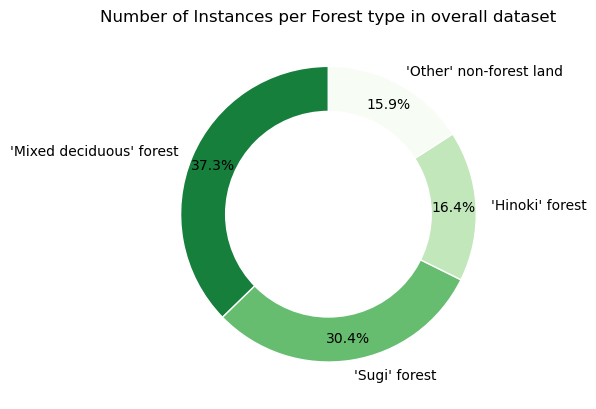

In [10]:
# Counting the number of instance in each class in the overall dataset
label_counts = forest_combine["class"].value_counts()

# Plotting the counts in a donut chart
fig_donut, ax_donut = plt.subplots()
label_dict = {'s':"'Sugi' forest", 'd': "'Mixed deciduous' forest", 'h':"'Hinoki' forest", 'o': "'Other' non-forest land" }
long_labels = forest_combine['class'].map(label_dict)
green_colors = plt.cm.Greens_r(np.linspace(0.2, 1, len(label_counts)))
ax_donut.pie(label_counts, labels=long_labels.unique(), colors=green_colors,
             autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Number of Instances per Forest type in overall dataset")
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig_donut.gca().add_artist(centre_circle)
plt.show()

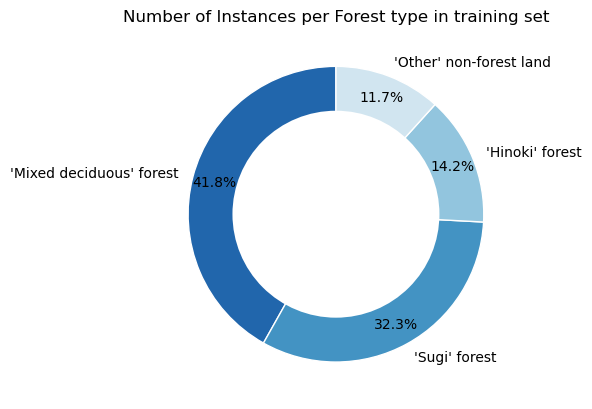

In [11]:
# Counting the number of instance in each class in the training dataset
train_label_counts = forest_train_classi["class"].value_counts()

# Plotting the counts in a donut chart
fig_train_donut, ax_train_donut = plt.subplots()
long_labels_train = forest_train['class'].map(label_dict)
ax_train_donut.pie(train_label_counts, labels=long_labels_train.unique(), 
             colors=['#2166AC', '#4393C3', '#92C5DE', '#D1E5F0'],
             autopct='%1.1f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_train_donut.set_title("Number of Instances per Forest type in training set")
centre_circle_train = plt.Circle((0,0),0.70,fc='white')
fig_train_donut.gca().add_artist(centre_circle_train)
plt.show()

From the above donut charts, though we can see there are more 'Mixed decidupus' forest and 'Sugi' forest than 'Hinoki' forest and 'Other' non-forest land, the imbalance is not significant. We believe it is still a reasonable balance for conducting further analysis.

However, we have to be aware if there are any sampling bias occur in the dataset (we may resample or assign different weights to each class during training process), or if the proportion of the whole forest population follows such pattern (i.e. the sampling was performed in stratafied sampling method). 

### 1.1.5 Transformation

#### 1.1.5.1 Feature scaling

As we mentioned above in the data exploration, we had observed there are some features are having very different scales. For example, the range of value in b6 is between 83 and 139, while that of b8 is between 19 and 84. Since certain Machine Learning algorithms do not perform well when numerical attributes have very different scales, we have to re-scale all the features on both training and testing set to ensure same feature scale by normalisation or standardisation. 

Since we had also noticed some of the attributes are right-skewed because of outliers in the previous section, we rescaled the features by standardisation as it is less affected by outliers than normalisation. 

In [12]:
scaler = StandardScaler()

# Splitting the independent and dependent variables
forest_train_x = forest_train_classi.drop("class", axis = 1)
forest_train_y = forest_train_classi["class"].copy()
forest_test_x = forest_test_classi.drop("class", axis = 1)
forest_test_y = forest_test_classi["class"].copy()

# Standardisation on attributes
forest_train_x_rescaled = scaler.fit_transform(forest_train_x)
forest_test_x_rescaled = scaler.transform(forest_test_x)

# Combining the dependent variable and rescaled features
forest_train_rescaled = pd.DataFrame(forest_train_x_rescaled, columns=forest_train_x.columns)
train_labels = forest_train_classi.select_dtypes(include=["object"]).columns
forest_train_rescaled[train_labels] = forest_train_classi[train_labels]

forest_test_rescaled = pd.DataFrame(forest_test_x_rescaled, columns=forest_test_x.columns)
test_labels = forest_test_classi.select_dtypes(include=["object"]).columns
forest_test_rescaled[test_labels] = forest_test_classi[test_labels]

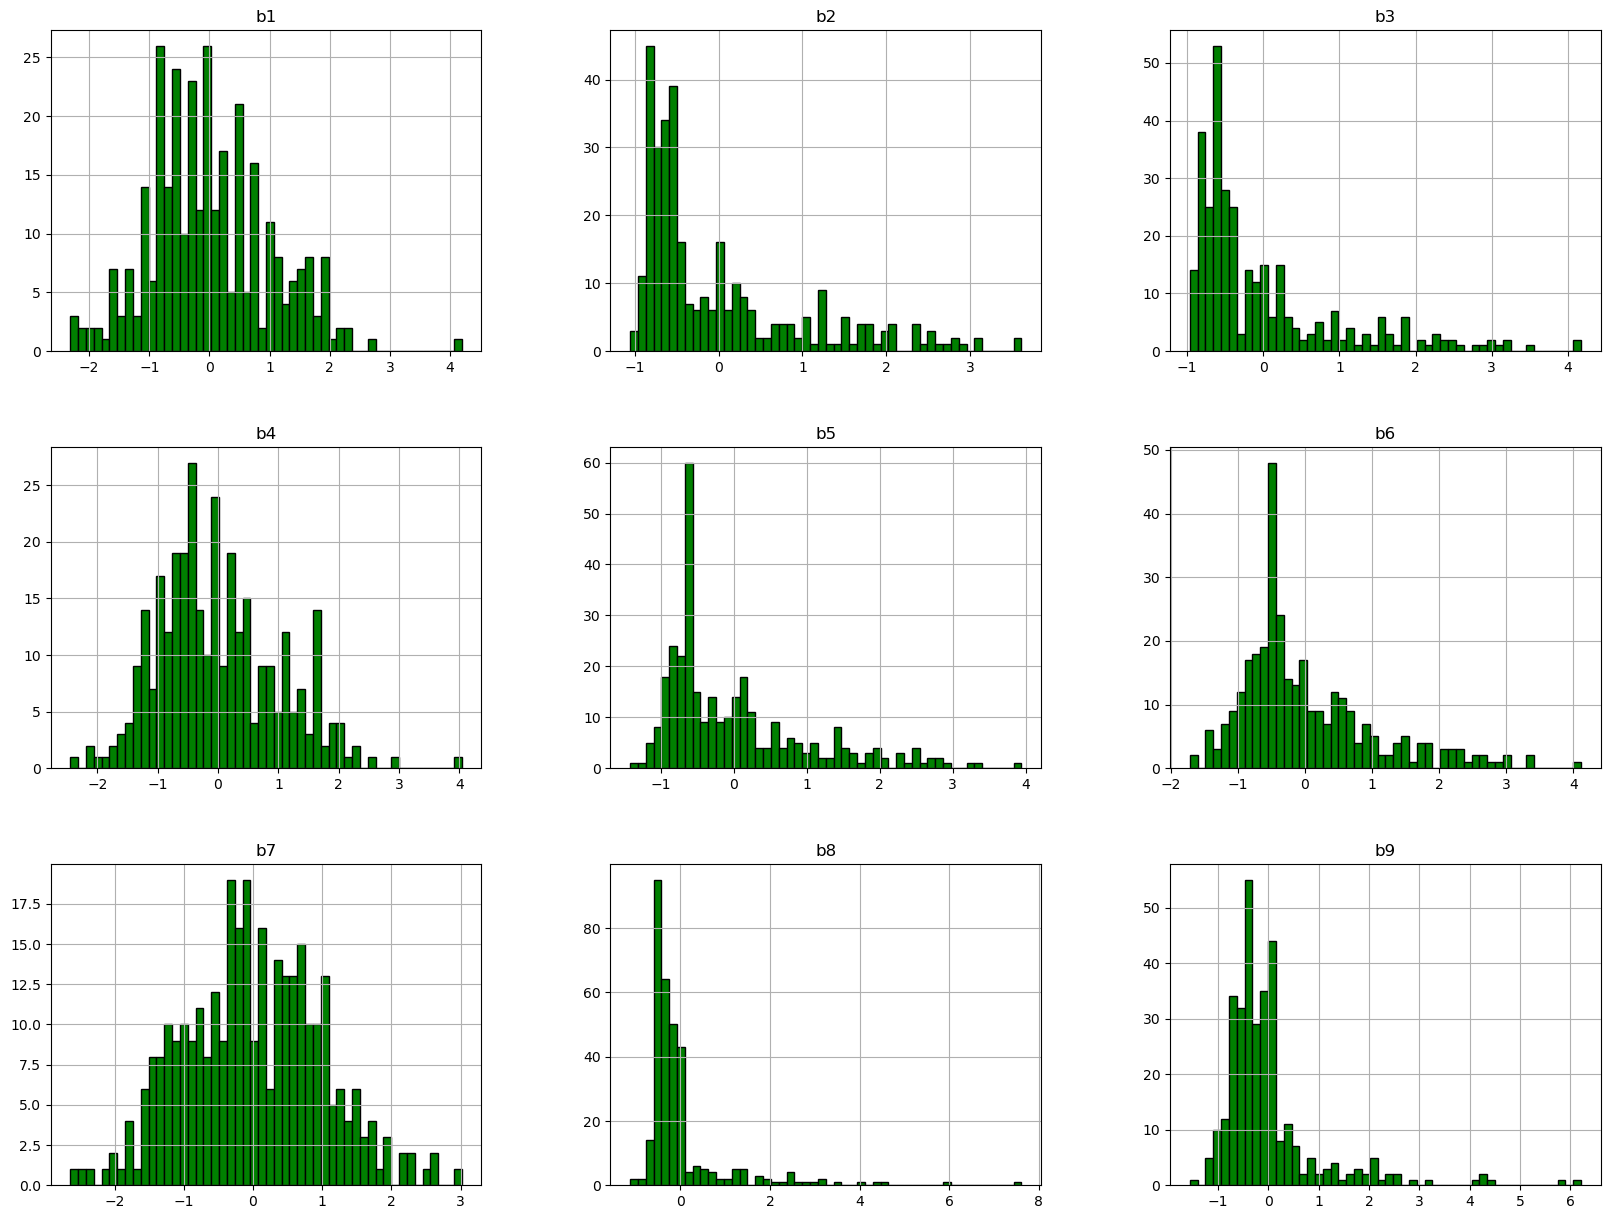

In [13]:
forest_train_rescaled.hist(bins=50, figsize=(20,15), color = "green", edgecolor = "black")
plt.show()

From the above histograms, we could see all of the features are now having mean = 0 and standard deviation = 1. Though there are some outliers noted in some features, the distributions of all features are approximately normal distributed. We therefore consider them to be reasonable to proceed.

#### 1.1.5.2 Handling Text and Categorical Attribute

Since most of the Machine Learning algorithms prefer to work with numbers, we will convert the qualitative categorical variable "class" from text into numbers: "d" = 0, "s" = 1, "o" = 2 and "h" = 3.

In [14]:
# Define the custom mapping
forest_type_mapping = {'d': 0, 's': 1, 'o': 2, 'h': 3}

# Map the "class" column in the input data to the custom numbers
train_class_col = forest_train_rescaled[["class"]]
train_class_num = train_class_col["class"].map(forest_type_mapping)
test_class_col = forest_test_rescaled[["class"]]
test_class_num = test_class_col["class"].map(forest_type_mapping)

# Add the encoded column to the input data
forest_train_rescaled["class_num"] = train_class_num
forest_test_rescaled["class_num"] = test_class_num

forest_train_rescaled.head(10)

,b1,b2,b3,b4,b5,b6,b7,b8,b9,class,class_num
0,0.768240,0.866233,0.436060,1.695451,1.024724,1.252415,3.017089,0.487582,0.915332,d,0
1,0.768240,-0.712673,-0.698765,0.254401,-0.761240,-0.233114,-0.232568,-0.185016,0.013527,s,1
2,0.425981,-0.849969,-0.765519,-0.105862,-0.855238,-0.869769,-0.292747,-0.185016,-0.211924,s,1
3,0.425981,0.248400,0.102288,0.074270,0.742729,0.934087,1.512618,0.084023,0.013527,d,0
4,-1.028620,-0.781321,-0.765519,-1.186649,-0.667242,-0.975878,-0.593641,-0.185016,-0.324650,s,1
5,0.083722,1.415417,1.504131,-0.285993,1.118722,0.509651,0.369220,0.218543,-0.099199,d,0
6,2.137276,-0.712673,-0.498501,1.875582,-0.667242,-0.339223,1.151545,-0.050497,0.577155,h,3
7,0.425981,-0.094840,-0.231484,-0.105862,-0.009255,0.191323,0.188684,-0.050497,0.351704,o,2
8,1.623888,-0.644024,-0.632010,0.614663,-0.667242,-0.657550,0.068326,-0.050497,0.013527,s,1
9,-0.087408,0.385697,0.235797,0.974926,0.084743,0.509651,0.730293,-0.185016,0.013527,d,0


## 1.2 Binary Classification

In this section, we performed binary classifications in only 2 of the classes: "s" ("Sugi" forest) and "d" ("Mixed deciduous" forest) by applying (i) Logistic Regression Classifier and (ii) k-nearest neighbours algorithms. 

To conduct such binary classification, we first filtered all the instances regarding "s" and "d" forest types from the dataset. While as we are extracting instances related to "s" and "d" and thus the population (also mean and standard deviation) has changed, the feature scaling we performed on the whole dataset in the previous section is no longer applicable. Thus, we performed features transformation again on the extracted dataset. 

As for the imbalance classes we mentioned earlier, it has no impact in this section since "s" (56%) and "d" (44%) have balanced distribution among the training set.

In [15]:
# Filtering the dataset for only "s" and "d" forest type
forest_train_sd = forest_train_classi.loc[(forest_train_classi['class'] == 's') |
                                      (forest_train_classi['class'] == 'd'), :].copy()
forest_test_sd = forest_test_classi.loc[(forest_test_classi['class'] == 's') | 
                                    (forest_test_classi['class'] == 'd'),:].copy()

# Counting the number of instance in each class in the training dataset
label_sd_counts = forest_train_sd["class"].value_counts()
label_sd_proportions = label_sd_counts / len(forest_train_sd)*100

label_sd_info = pd.DataFrame({'Count': label_sd_counts, 'Proportion': label_sd_proportions.map("{:.2f}%".format)})
print(label_sd_info)

   Count Proportion
s    136     56.43%
d    105     43.57%


In [16]:
# Converting the categorical variable (forest types) to numerical ('d' = 0, 's' = 1)
train_class_sd_col = forest_train_sd.loc[:,["class"]].copy()
train_class_sd_num = train_class_sd_col["class"].map(forest_type_mapping)
test_class_sd_col = forest_test_sd.loc[:,["class"]].copy()
test_class_sd_num = test_class_sd_col["class"].map(forest_type_mapping)

forest_train_sd.loc[:,"class_num"] = train_class_sd_num
forest_test_sd.loc[:,"class_num"] = test_class_sd_num

# Feature scaling
forest_sd_train_x = forest_train_sd.drop(["class", "class_num"], axis = 1)
forest_sd_test_x = forest_test_sd.drop(["class", "class_num"], axis = 1)
forest_sd_train_y = forest_train_sd["class_num"].copy()
forest_sd_test_y = forest_test_sd["class_num"].copy()

# Standardisation 
forest_sd_train_x_rescaled = scaler.fit_transform(forest_sd_train_x)
forest_sd_test_x_rescaled = scaler.transform(forest_sd_test_x)

# Converting the rescaled features into dataframes
forest_sd_train_rescaled = pd.DataFrame(forest_sd_train_x_rescaled, columns=forest_sd_train_x.columns)
forest_sd_train_y_df = pd.DataFrame(forest_sd_train_y, columns=['class_num'])
forest_sd_train_y_df = forest_sd_train_y.reset_index(drop=True)
forest_sd_train_rescaled = pd.concat([forest_sd_train_rescaled, forest_sd_train_y_df], axis = 1)

forest_sd_test_rescaled = pd.DataFrame(forest_sd_test_x_rescaled, columns=forest_sd_test_x.columns)
forest_sd_test_y_df = pd.DataFrame(forest_sd_test_y, columns=['class_num'])
forest_sd_test_y_df = forest_sd_test_y.reset_index(drop=True)
forest_sd_test_rescaled = pd.concat([forest_sd_test_rescaled, forest_sd_test_y_df], axis = 1)

# Previewing the rescaled dataset
forest_sd_train_rescaled.head(10)

,b1,b2,b3,b4,b5,b6,b7,b8,b9,class_num
0,1.309800,1.385874,0.864596,2.362836,1.842379,2.185241,3.373114,2.524537,2.936337,0
1,1.309800,-0.683046,-0.649833,0.574593,-0.816384,0.012237,-0.100905,0.340713,0.797592,1
2,0.880911,-0.862952,-0.738917,0.127533,-0.956319,-0.919051,-0.165239,0.340713,0.262906,1
3,0.880911,0.576297,0.419175,0.351063,1.422575,1.719597,1.764772,1.214242,0.797592,0
4,-0.941863,-0.772999,-0.738917,-1.213649,-0.676449,-1.074265,-0.486907,0.340713,-0.004437,1
5,0.452023,2.105499,2.289940,-0.095997,1.982314,1.098739,0.542432,1.651007,0.530249,0
6,2.382020,-0.593093,-0.560749,1.021654,-0.676449,-0.608621,0.220763,0.777478,0.797592,1
7,0.237579,0.756203,0.597344,1.468714,0.443030,1.098739,0.928434,0.340713,0.797592,0
8,1.095355,-0.593093,-0.560749,0.798124,-0.676449,-0.298192,0.349431,1.214242,1.599621,1
9,-1.049085,0.036578,0.151923,0.351063,0.163161,0.788310,-0.036571,1.214242,-0.004437,0


In [17]:
# Separating dependant and indepandent variables
forest_sd_train_x_rescaled = forest_sd_train_rescaled.drop("class_num", axis =1)
forest_sd_train_y_rescaled = forest_sd_train_rescaled[["class_num"]].copy().values.ravel()
forest_sd_test_x_rescaled = forest_sd_test_rescaled.drop("class_num", axis =1)
forest_sd_test_y_rescaled = forest_sd_test_rescaled[["class_num"]].copy()

### 1.2.1 Logistic Regression Classifier

In [18]:
# Fitting a Logistic Regression Classifier
forest_sd_lr = LogisticRegression(random_state=901)
forest_sd_lr.fit(forest_sd_train_x_rescaled, forest_sd_train_y_rescaled)

LogisticRegression(random_state=901)

In [19]:
# Looking at some predictions from the testing set
some_data = forest_sd_test_x_rescaled.iloc[:5]
some_labels = forest_sd_test_y_rescaled.iloc[:5]
print("Predictions:", forest_sd_lr.predict(some_data))
print("Labels:", some_labels.values.flatten().tolist())

Predictions: [0 1 1 0 1]
Labels: [0, 1, 1, 0, 1]


After fitting the Logistic Regression Classifier, we performed some predictions on the testing set by selecting 5 instances. The classifier classified all 5 instances correctly. In order to see if the above predictions are correct by chance, we will preliminarily evaluate the performance of the classifier by computing confusion matrix, accuracy score and RMSE. More detailed performance evaluation (such as precision/recall and ROC) will be performed in section 1.2.1.2.

In [20]:
# Computing the confusion matrix
sd_logreg_predictions = forest_sd_lr.predict(forest_sd_test_x_rescaled)
print("Preliminary performance measures for Logistic Regression Classifier:\n")
print("Confusion Matrix: ")
print(confusion_matrix(forest_sd_test_y_rescaled, sd_logreg_predictions))

# Computing the accuracy score
score = forest_sd_lr.score(forest_sd_test_x_rescaled, forest_sd_test_y_rescaled)
print("\nAccuracy score: {:.4f}".format(score))

# Computing the root mean squared error (RMSE)
sd_logreg_mse = mean_squared_error(forest_sd_test_y_rescaled, sd_logreg_predictions) 
sd_logreg_rmse = np.sqrt(sd_logreg_mse)
print("RMSE: {:.4f}".format(sd_logreg_rmse))

Preliminary performance measures for Logistic Regression Classifier:

Confusion Matrix: 
[[54  0]
 [ 1 58]]

Accuracy score: 0.9912
RMSE: 0.0941


From the above 3 performance measures, they indicate the performance in classifying forests into "s" and "d" of the Logistic Regression Classifier is quite satisfactory.

(i) Confusion matrix: Among the test set, there is only 1 instance incorrectly classified. The instance is in "d" type, but misclassified to be "s" type. However, the performance is satisifactory since most of the instances are in the main diagonal, suggesting thet are correctly classified.

(ii) Accuracy: Accuracy scores are values in the range [0,1], while higher value indicate a better performance. The Logistic Regression Classifier has an accuracy score of 0.9912 which is very high indicating it classifies forest types very accurately.

(iii) RMSE: Smaller RMSE indicates a better performance. The Logistic Regression Classifier has a RMSE of 0.0941 which is very low indicating errors made by the classifier is very small.

#### 1.2.1.1 Estimated probabilities and decision boundary

#### (i)  Individual features - b5

In [21]:
# Training a Logistic Regression Classifier on feature "b5"
X_train_b5 = forest_sd_train_rescaled["b5"].values.reshape(-1,1)
y_train_b5 = forest_sd_train_rescaled["class_num"]
X_test_b5 = forest_sd_test_rescaled["b5"].values.reshape(-1,1)
y_test_b5 = forest_sd_test_rescaled["class_num"]

forest_sd_lr.fit(X_train_b5, y_train_b5)

LogisticRegression(random_state=901)

In [22]:
# Estimated probabilities and decision boundary of "b5"
min_b5 = np.min(forest_sd_train_rescaled["b5"].values)
max_b5 = np.max(forest_sd_train_rescaled["b5"].values)

X_new_b5 = np.linspace(min_b5, max_b5, 1000).reshape(-1,1)
y_train_b5_proba = forest_sd_lr.predict_proba(X_new_b5)

threshold_b5 = 0.5
decision_boundary_b5 = X_new_b5[y_train_b5_proba[:, 0] >= threshold_b5][0]
print("Decision boundary of b5 is {:.4f}".format(decision_boundary_b5[0]))

Decision boundary of b5 is 0.0270


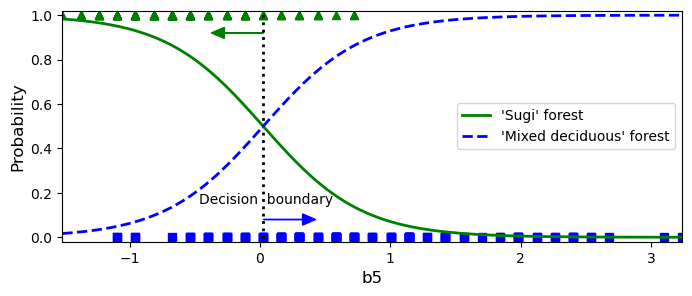

In [23]:
# Plotting the estimated probabilities and decision boundary
plt.figure(figsize=(8, 3))
plt.plot(X_train_b5[y_train_b5 == 0], y_train_b5[y_train_b5 == 0], "bs")
plt.plot(X_train_b5[y_train_b5 == 1], y_train_b5[y_train_b5 == 1], "g^")
plt.plot([decision_boundary_b5, decision_boundary_b5], [-3, 3], "k:", linewidth=2)
plt.plot(X_new_b5, y_train_b5_proba[:, 1], "g-", linewidth = 2, label = "'Sugi' forest")
plt.plot(X_new_b5, y_train_b5_proba[:, 0], "b--", linewidth = 2, label = "'Mixed deciduous' forest")
plt.text(decision_boundary_b5+0.02, 0.15, "Decision  boundary", fontsize=10, color="k", ha="center")
plt.arrow(decision_boundary_b5, 0.92, -0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.arrow(decision_boundary_b5, 0.08, 0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.xlabel("b5", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.legend(loc = "center right", fontsize = 10)
plt.axis([min_b5, max_b5, -0.02, 1.02])
plt.show()

From the above, we can see the b5 values for 'Sugi' forests range between -1.5 and 0.75, while the b5 values for 'Mixed deciduous' forest range between -1.2 and 3.25. For b5 values above 1 are highly confident that the forest is in 'Mixed deciduous' forest type, while b5 values below -1.2 are highly confident that the forest is in 'Sugi' forest type. However, in between these values, the classification is unsure that we can see there are few instances have been wrongly classified by setting our b5 value threshold to be 0.027 (where both probabilities are equal to 0.5). 

In [24]:
# Computing the confusion matrix
sd_logreg_predictions_b5 = forest_sd_lr.predict(X_test_b5)

print("Performance measures for Logistic Regression Classifier (b5):\n")
print("Confusion Matrix: ")
print(confusion_matrix(y_test_b5, sd_logreg_predictions_b5))

# Computing the accuracy score
score_b5 = forest_sd_lr.score(X_test_b5, y_test_b5)
print("\nAccuracy score: {:.4f}".format(score_b5))

# Computing the root mean squared error (RMSE)
sd_logreg_mse_b5 = mean_squared_error(y_test_b5, sd_logreg_predictions_b5) 
sd_logreg_rmse_b5 = np.sqrt(sd_logreg_mse_b5)
print("RMSE:{:.4f}".format(sd_logreg_rmse_b5))

Performance measures for Logistic Regression Classifier (b5):

Confusion Matrix: 
[[49  5]
 [ 4 55]]

Accuracy score: 0.9204
RMSE:0.2822


Though there are few instances got wrongly classified by b5, the performance of b5 are quite satisfactory when looking at the confusion matrix, accuracy score and RMSE. However, when it comes to the conclusion of whether b5 is a satisfactory predictor, more studies have to be made (such as comparing the performance with multivariables models).

So comparing to the performance of the model trained with all features, b5 classifier performs poorer with having more misclassifications noted in the confusion matrix, lower accuracy and higher RMSE. It suggests that we may have to consider more features to classify forest types accurately, instead of solely by b5.

#### (ii)  Individual features - b8

In [25]:
# Training a Logistic Regression Classifier on feature "b8"
X_train_b8 = forest_sd_train_rescaled["b8"].values.reshape(-1,1)
y_train_b8 = forest_sd_train_rescaled["class_num"]
X_test_b8 = forest_sd_test_rescaled["b8"].values.reshape(-1,1)
y_test_b8 = forest_sd_test_rescaled["class_num"]

forest_sd_lr.fit(X_train_b8, y_train_b8)

LogisticRegression(random_state=901)

In [26]:
# Estimated probabilities and decision boundary of "b8"
min_b8 = np.min(forest_sd_train_rescaled["b8"].values)
max_b8 = np.max(forest_sd_train_rescaled["b8"].values)

X_new_b8 = np.linspace(min_b8, max_b8, 1000).reshape(-1,1)
y_train_b8_proba = forest_sd_lr.predict_proba(X_new_b8)

threshold_b8 = 0.5
decision_boundary_b8 = X_new_b8[y_train_b8_proba[:, 0] >= threshold_b8][0]

print("Decision boundary of b8 is {:.4f}".format(decision_boundary_b8[0]))

Decision boundary of b8 is 0.2817


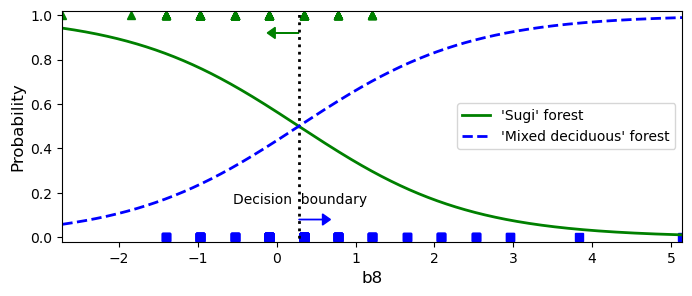

In [27]:
# Plotting the estimated probabilities and decision boundary
plt.figure(figsize=(8, 3))
plt.plot(X_train_b8[y_train_b8 == 0], y_train_b8[y_train_b8 == 0], "bs")
plt.plot(X_train_b8[y_train_b8 == 1], y_train_b8[y_train_b8 == 1], "g^")
plt.plot([decision_boundary_b8, decision_boundary_b8], [-3, 3], "k:", linewidth=2)
plt.plot(X_new_b8, y_train_b8_proba[:, 1], "g-", linewidth = 2, label = "'Sugi' forest")
plt.plot(X_new_b8, y_train_b8_proba[:, 0], "b--", linewidth = 2, label = "'Mixed deciduous' forest")
plt.text(decision_boundary_b8+0.02, 0.15, "Decision  boundary", fontsize=10, color="k", ha="center")
plt.arrow(decision_boundary_b8, 0.92, -0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.arrow(decision_boundary_b8, 0.08, 0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.xlabel("b8", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.legend(loc = "center right", fontsize = 10)
plt.axis([min_b8, max_b8, -0.02, 1.02])
plt.show()

From the above, we can see the b8 values for 'Sugi' forests range between -2.5 and 1.1, while the b8 values for 'Mixed deciduous' forest range between -1.5 and 5.25. For b8 values above 1.5 are highly confident that the forest is in 'Mixed deciduous' forest type, while b8 values below -1.5 are highly confident that the forest is in 'Sugi' forest type. However, in between these values, the classification is unsure that we can see there are few instances have been wrongly classified by setting our b5 value threshold to be 0.2817 (where both probabilities are equal to 0.5). 

The estimated probabilities curves are not as sigmoid as that of b5, which indicate the "confident" range for b8 is smaller than b5. b5 seems to be a better predictor of the forest types than b8.

In [28]:
# Computing the confusion matrix
sd_logreg_predictions_b8 = forest_sd_lr.predict(X_test_b8)

print("Performance measures for Logistic Regression Classifier (b8):\n")
print("Confusion Matrix: ")
print(confusion_matrix(y_test_b8, sd_logreg_predictions_b8))

# Computing the accuracy score
score_b8 = forest_sd_lr.score(X_train_b8, y_train_b8)
print("\nAccuracy Score: {:.4f}".format(score_b8))

# Computing the root mean squared error (RMSE)
sd_logreg_mse_b8 = mean_squared_error(y_test_b8, sd_logreg_predictions_b8) 
sd_logreg_rmse_b8 = np.sqrt(sd_logreg_mse_b8)
print("RMSE: {:.4f}".format(sd_logreg_rmse_b8))

Performance measures for Logistic Regression Classifier (b8):

Confusion Matrix: 
[[34 20]
 [11 48]]

Accuracy Score: 0.6639
RMSE: 0.5238


Looking at the performance measures of b8, we can note that there are more false predictions from the confusion matrix, lower accuracy score and higher RMSE as compared to b5. These findings are align with the above estimated probabilities curves, which indicate b5 may be a better predictor than b8. 

#### (iii) All features

In [29]:
# Fitting logistic regression classifier with all features
forest_sd_lr.fit(forest_sd_train_x_rescaled, forest_sd_train_y_rescaled)

# Randomly select 10 instances from testing set
X_test_10 = forest_sd_test_x_rescaled.sample(n=10, random_state=20)
y_test_10 = forest_sd_test_y_rescaled.loc[X_test_10.index].values

# Calculating the scores of these 10 testing instances
X_score_10 = forest_sd_lr.intercept_ + np.dot(X_test_10, forest_sd_lr.coef_.T)

# Calculating the scores of all testing instances (to determine the range of scores)
X_score_all = forest_sd_lr.intercept_ + np.dot(forest_sd_test_x_rescaled, forest_sd_lr.coef_.T)
X_new_all = np.linspace(X_score_all.min(), X_score_all.max(), 1000).reshape(-1,1)

# Computing estimated probabilities by sigmoid function
y_all_proba = 1 / (1 + np.exp(- X_new_all))

# Computing the decision boundary
threshold_all = 0.5
decision_boundary_all = X_new_all[y_all_proba[:, 0] >= threshold_all][0]

print("Decision boundary is {:.4f}".format(decision_boundary_all[0]))

Decision boundary is 0.0007


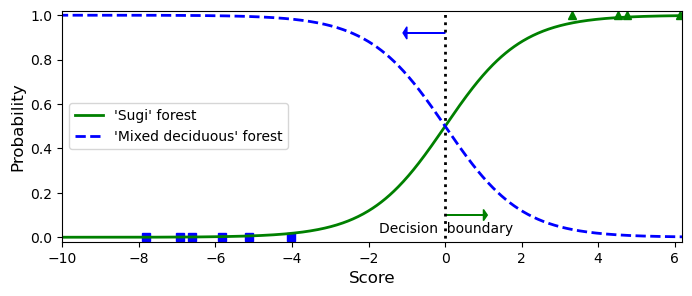

In [30]:
# Plotting the estimated probabilities and decision boundary
plt.figure(figsize=(8, 3))
plt.plot(X_score_10[y_test_10 == 0], y_test_10[y_test_10 == 0], "bs")
plt.plot(X_score_10[y_test_10 == 1], y_test_10[y_test_10 == 1], "g^")
plt.plot([decision_boundary_all, decision_boundary_all], [-1, 2], "k:", linewidth=2)
plt.plot(X_new_all, y_all_proba, "g-", linewidth = 2, label = "'Sugi' forest")
plt.plot(X_new_all, 1 - y_all_proba, "b--", linewidth = 2, label = "'Mixed deciduous' forest")
plt.text(decision_boundary_all+0.02, 0.02, "Decision  boundary", fontsize=10, color="k", ha="center")
plt.arrow(decision_boundary_all, 0.92, -1, 0, head_width=0.055, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary_all, 0.1, 1, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Score", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.legend(loc = "center left", fontsize = 10)
plt.axis([-10, X_score_all.max(), -0.02, 1.02])
plt.show()

From the above, for scores below -4 are highly confident that the forest is in 'Mixed deciduous' forest type, while scores over 3 are highly confident that the forest is in 'Sugi' forest type. Decision boundary has been set in approximately 0 score (where both probabilities are equal to 0.5). We have randomly selecting 10 instances from the testing set (as shown in the above plot), all of them are classified in the appropriate forest types according to the 50% decision boundary. 

Further performance measures will be performed in the next section.

#### 1.2.1.2 Precision-Recall tradeoff

In [31]:
forest_sd_train_y_pred = cross_val_predict(forest_sd_lr, 
                                           forest_sd_train_x_rescaled, forest_sd_train_y_rescaled, 
                                           cv=3)

precision_lr = precision_score(forest_sd_train_y_rescaled, forest_sd_train_y_pred)
recall_lr = recall_score(forest_sd_train_y_rescaled, forest_sd_train_y_pred)
f1_lr = f1_score(forest_sd_train_y_rescaled, forest_sd_train_y_pred)

print("Performance measures for Logistic Regression Classifier (all features):")
print("\nPrecision: {:.4f}".format(precision_lr))
print("Recall: {:.4f}".format(recall_lr))
print("F1 Score: {:.4f}".format(f1_lr))

Performance measures for Logistic Regression Classifier (all features):

Precision: 0.9424
Recall: 0.9632
F1 Score: 0.9527


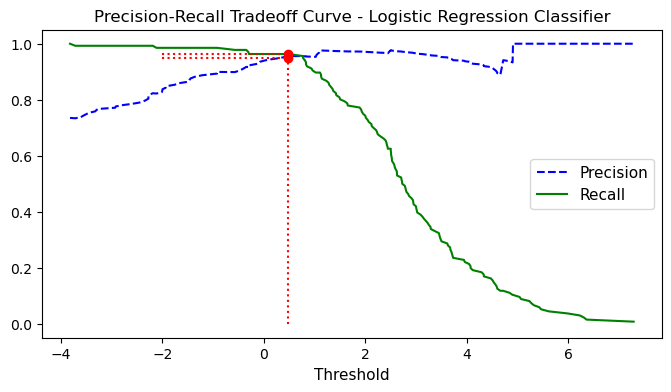

In [32]:
# Obtaining all scores on predictions
y_scores_lr = cross_val_predict(forest_sd_lr, forest_sd_train_x_rescaled, forest_sd_train_y_rescaled, 
                                cv=3, method="decision_function")

# Plotting precision verse recall curve
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(forest_sd_train_y_rescaled, y_scores_lr)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=11) 
    plt.xlabel("Threshold", fontsize=11)        
    plt.grid(True)                            
    
recall_95_precision = recalls_lr[np.argmax(precisions_lr >= 0.95)]
threshold_95_precision = thresholds_lr[np.argmax(precisions_lr >= 0.95)]

plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions_lr, recalls_lr, thresholds_lr)
plt.plot([threshold_95_precision, threshold_95_precision], [0., 0.95], "r:")                 
plt.plot([-2, threshold_95_precision], [0.95, 0.95], "r:")                                
plt.plot([-2, threshold_95_precision], [recall_95_precision, recall_95_precision], "r:")
plt.plot([threshold_95_precision], [0.95], "ro")                                             
plt.plot([threshold_95_precision], [recall_95_precision], "ro")
plt.title("Precision-Recall Tradeoff Curve - Logistic Regression Classifier")
plt.grid(False)
plt.show()

From the above precision-recall tradeoff curve, we can notice that the recall drops dramatically after passing the threshold of around 0.75, while the precision continues to increase with the incresing threshold (though there is a little drop observed when threshold is around 4.5). 

Since we are not able to have both increasing precision and recall, we have to decide which of these performance measures is considered to be more important for the analysis. In this case, we are predicting forest types to identify the ecosystem services (e.g. carbon storage, erosion protection) provided by the forest. To have more accurate subsequent research, precision is considered to be more important than recall. 

From the above curve, threshold is set on approximately 95% precision is considered to be reasonable, as it is before the significant drop in recall and hence provides us with good precision-recall balance. 

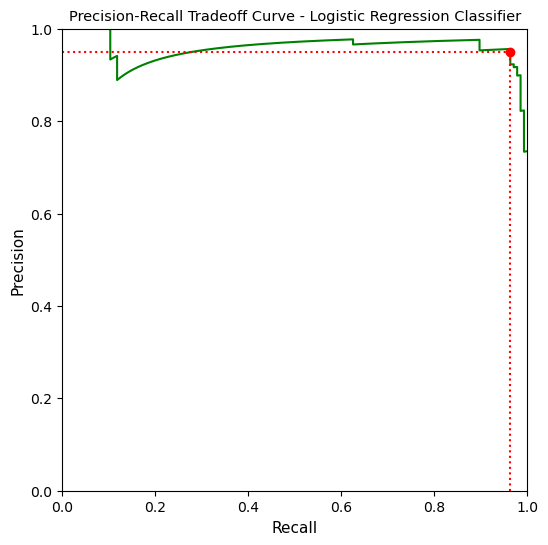

In [33]:
# Plotting another precision vs recall curve
plt.figure(figsize=(6, 6)) 
plt.plot(recalls_lr, precisions_lr, color = 'green')
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.plot([recall_95_precision, recall_95_precision], [0, 0.95], "r:")
plt.plot([0.0, recall_95_precision], [0.95, 0.95], "r:")
plt.plot([recall_95_precision], [0.95], "ro")
plt.title("Precision-Recall Tradeoff Curve - Logistic Regression Classifier", fontsize=10.5)
plt.grid(False)
plt.show()

We plotted another precision-recall tradeoff curve to confirm our decision in setting 95% precision as our threshold. From the above curve, 95% precision is before the signification drop of precision and keeping a satisfactory recall, which is considered to be reasonable.

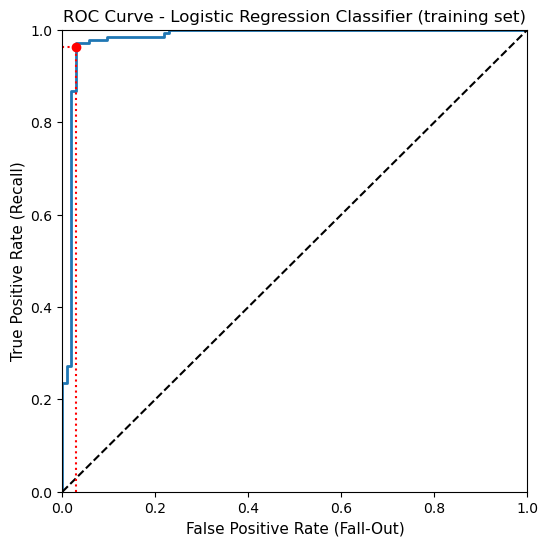

In [34]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)    
    plt.grid(True)                                            

y_scores_lr_train = forest_sd_lr.decision_function(forest_sd_train_x_rescaled)
fpr_lr_train, tpr_lr_train, thresholds_roc_lr_train = roc_curve(forest_sd_train_y_rescaled, y_scores_lr_train)

plt.figure(figsize=(6, 6))                                    
plot_roc_curve(fpr_lr_train, tpr_lr_train) 
fpr_95 = fpr_lr_train[np.argmax(tpr_lr_train >= recall_95_precision)]
plt.plot([fpr_95, fpr_95], [0., recall_95_precision], "r:")   
plt.plot([0.0, fpr_95], [recall_95_precision, recall_95_precision], "r:")  
plt.plot([fpr_95], [recall_95_precision], "ro")   
plt.title("ROC Curve - Logistic Regression Classifier (training set)")
plt.grid()
plt.show()

From the above ROC curve, there is a tradeoff between True Positive Rate and False Positive Rate by setting different thresholds. In this case, we are setting a threshold of 95% precision, where recall is similar to 95% as well. This threshold is considered to be reasonable since it obtains a very high recall with a mere increase in Fall-Out (~0.02). However, if we increase the recall threshold by 5% to 100%, the Fall-Out will increase to 0.225 sharply, which suggests a poorer performance of Logistic Regression Classifier.

### 1.2.2 k-nearest neighbours (k-NN) algorithm

In [35]:
# Trying different k values (1 - 10)
ks = range(1,11)

accuracies_knns = []
precisions_knns = []
recalls_knns = []

# Training and evaluating a k-NN classifier for each k value
for k in ks:
    forest_sd_knns = KNeighborsClassifier(n_neighbors=k)
    forest_sd_knns.fit(forest_sd_train_x_rescaled, forest_sd_train_y_rescaled)
    knns_y_pred = forest_sd_knns.predict(forest_sd_test_x_rescaled)
    accuracies_knns.append(accuracy_score(forest_sd_test_y_rescaled, knns_y_pred))
    precisions_knns.append(precision_score(forest_sd_test_y_rescaled, knns_y_pred))
    recalls_knns.append(recall_score(forest_sd_test_y_rescaled, knns_y_pred))
    print(f"k={k},Accuracy={accuracies_knns[-1]:.4f}, Precision={precisions_knns[-1]:.4f}, Recall={recalls_knns[-1]:.4f}")

k=1,Accuracy=0.9823, Precision=0.9831, Recall=0.9831
k=2,Accuracy=0.9823, Precision=1.0000, Recall=0.9661
k=3,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=4,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=5,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=6,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=7,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=8,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=9,Accuracy=0.9912, Precision=1.0000, Recall=0.9831
k=10,Accuracy=0.9912, Precision=1.0000, Recall=0.9831


From the above result, we can see that all the scores have reached the peak and become stable after k = 3. Thus, we will choose k = 3 for our k-NN algorithm in binary classification as a smaller k can also reduce the training time and complexity of the model.

In [36]:
# Training a model by k-NN algorithm with k = 3
final_k = 3
forest_sd_knn = KNeighborsClassifier(n_neighbors=final_k)

forest_sd_knn.fit(forest_sd_train_x_rescaled, forest_sd_train_y_rescaled)

KNeighborsClassifier(n_neighbors=3)

In [37]:
knn_y_pred = forest_sd_knn.predict(forest_sd_test_x_rescaled)

acc_knn = accuracy_score(forest_sd_test_y_rescaled, knn_y_pred)
prec_knn = precision_score(forest_sd_test_y_rescaled, knn_y_pred)
recall_knn = recall_score(forest_sd_test_y_rescaled, knn_y_pred)

print(f"k={final_k}, Accuracy={acc_knn:.4f}, Precision={prec_knn:.4f}, Recall={recall_knn:.4f}")

k=3, Accuracy=0.9912, Precision=1.0000, Recall=0.9831


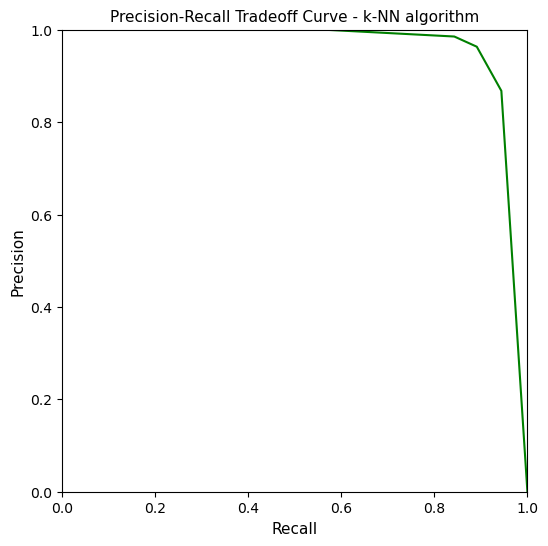

In [38]:
# Plotting precision vs recall curve
y_scores_knn = cross_val_predict(forest_sd_knn, forest_sd_train_x_rescaled, forest_sd_train_y_rescaled, 
                                cv=3, method='predict_proba')
precisions_knn, recalls_knn, thresholds_knn = precision_recall_curve(forest_sd_train_y_rescaled, y_scores_knn[:,1])

plt.figure(figsize=(6, 6)) 
plt.plot(precisions_knn, recalls_knn, color = 'green')
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title("Precision-Recall Tradeoff Curve - k-NN algorithm", fontsize=11)
plt.grid(False)
plt.show()

### 1.2.3 Logistic regression classifier vs k-NN algorithm

In [39]:
forest_sd_test_y_pred_lr = forest_sd_lr.predict(forest_sd_test_x_rescaled)
y_scores_lr_test = forest_sd_lr.decision_function(forest_sd_test_x_rescaled)

# Evaluating the performance of Logistic Regression Classifier using various metrics
print("Performance Measures for Logistic Regression Classifier:\n")
print("Confusion Matrix:")
print(confusion_matrix(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr))
print("\nAccuracy: {:.4f}".format(accuracy_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr)))
print("Precision: {:.4f}".format(precision_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr)))
print("Recall: {:.4f}".format(recall_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr)))
print("F1-score: {:.4f}".format(f1_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr)))
print("ROC-AUC score: {:.4f}".format(roc_auc_score(forest_sd_test_y_rescaled, y_scores_lr_test)))

Performance Measures for Logistic Regression Classifier:

Confusion Matrix:
[[54  0]
 [ 1 58]]

Accuracy: 0.9912
Precision: 1.0000
Recall: 0.9831
F1-score: 0.9915
ROC-AUC score: 1.0000


In [40]:
forest_sd_test_y_pred_knn = forest_sd_knn.predict(forest_sd_test_x_rescaled)
y_scores_knn_test = forest_sd_knn.predict_proba(forest_sd_test_x_rescaled)[:,1]

# Evaluating the performance of k-NN algorithm using various metrics
print("Performance Measures for k-NN algorithm:\n")
print("Confusion Matrix:")
print(confusion_matrix(forest_sd_test_y_rescaled, forest_sd_test_y_pred_knn))
print("\nAccuracy: {:.4f}".format(accuracy_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_knn)))
print("Precision: {:.4f}".format(precision_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_knn)))
print("Recall: {:.4f}".format(recall_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_knn)))
print("F1-score: {:.4f}".format(f1_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_knn)))
print("ROC-AUC score: {:.4f}".format(roc_auc_score(forest_sd_test_y_rescaled, y_scores_knn_test)))

Performance Measures for k-NN algorithm:

Confusion Matrix:
[[54  0]
 [ 1 58]]

Accuracy: 0.9912
Precision: 1.0000
Recall: 0.9831
F1-score: 0.9915
ROC-AUC score: 0.9914


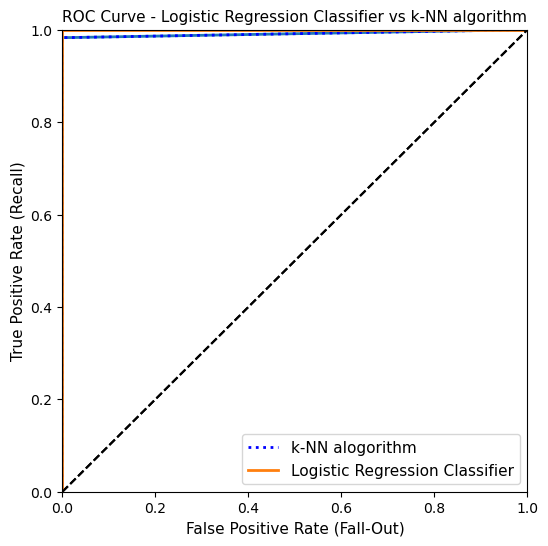

In [41]:
# Plotting ROC curves
fpr_lr, tpr_lr, thresholds_roc_lr = roc_curve(forest_sd_test_y_rescaled, y_scores_lr_test)
fpr_knn, tpr_knn, thresholds_roc_knn = roc_curve(forest_sd_test_y_rescaled, y_scores_knn_test)

plt.figure(figsize=(6, 6))                                    
plot_roc_curve(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, "b:", linewidth=2, label="k-NN alogorithm")
plot_roc_curve(fpr_lr, tpr_lr, "Logistic Regression Classifier")             
plt.legend(loc="lower right", fontsize=11)
plt.title("ROC Curve - Logistic Regression Classifier vs k-NN algorithm", fontsize=11)
plt.grid(False)
plt.show()

From the above performance measures, we can observe Logistics Regression Classifier and k-NN algorithm perform very satisfactorily in the testing set, with high precision, recall, accuracy and AUC (all values are over 0.98). These 2 algorithms have the same scores on precision, recall and accuracy, whereas the only difference is AUC value. Logistics Regression Classifier has a slightly higher AUC value of 1.0 as compared to 0.9914 in k-NN algorithm. A higher AUC value indicate better performance, thus Logistics Regression Classifier performs slightly better than k-NN algorithms. This is also consistent to the above ROC curves where Logistics Regression Classifier has a ROC curve closer to the top-left-corner than k-NN algorithm.

In this case, we have used 95% precision to be our threshold in the Logistic Regression Classifier. As mentioned in section 1.2.1.2, we have chosen this threshold since it provides us with the best balance between precision and recall (before the significant drop in recall while keeping a satisfactory precision value) and between True Positive Rate and False Positive Rate.

### 1.2.4 3-fold cross-validation

In [42]:
# Defining 3-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=901)

# Performing cross-validation for logistic regression classifier
lr_scores = cross_val_score(forest_sd_lr, forest_sd_train_x_rescaled, forest_sd_train_y_rescaled, cv=cv, scoring='accuracy')

# Function to present (i)accuracy scores for every fold, (ii) mean score and (iii) score standard deviation
def display_scores(scores):
    print("Accuracy scores:")
    for i, score in enumerate(scores):
        print("Fold {}: {:.4f}".format(i+1, score))
    print("Mean accuracy score: {:.4f}".format(scores.mean()))
    print("Standard deviation of accuracy score: {:.4f}".format(scores.std()))
    
# Printing scores of logistic regression classifier
print("Training set:")
print("Accuracy score:{:.4f}".format(accuracy_score(forest_sd_test_y_rescaled, forest_sd_test_y_pred_lr)))
print("\n3-fold cross-validation:")
display_scores(lr_scores)

Training set:
Accuracy score:0.9912

3-fold cross-validation:
Accuracy scores:
Fold 1: 0.9259
Fold 2: 0.9375
Fold 3: 0.9750
Mean accuracy score: 0.9461
Standard deviation of accuracy score: 0.0209


From the above, we can see the Logistic Regression Classifier performs better on its training set than unseen data in the 3-fold cross validation. However, since both accuracy scores are still very high and without significant difference, we believe this Logistic Regression Classifier performs well on the generalisation with no overfitting issue noted.

In [43]:
# Performing cross-validation for k-NN algorithm
knn_scores = cross_val_score(forest_sd_knn, forest_sd_train_x_rescaled, forest_sd_train_y_rescaled, cv=cv, scoring='accuracy')

# Printing scores of k-NN alogorithm
print("Training set:")
print("Accuracy score:{:.4f}".format(acc_knn))
print("\n3-fold cross-validation:")
display_scores(knn_scores)

Training set:
Accuracy score:0.9912

3-fold cross-validation:
Accuracy scores:
Fold 1: 0.9259
Fold 2: 0.8875
Fold 3: 0.9750
Mean accuracy score: 0.9295
Standard deviation of accuracy score: 0.0358


From the above, we can see the k-NN algorithm performs better on its training set than unseen data in the 3-fold cross validation. However, since both accuracy scores are still very high and without significant difference, we believe the k-NN algorithm performs well on the generalisation with no overfitting issue noted.

In [44]:
# Comparing mean accuracy scores for each classifier
print("Mean Accuracy Score:\n")
print(f'Logistic Regression Classifier: {lr_scores.mean():.4f}')
print(f'k-NN algorithm: {knn_scores.mean():.4f}')

Mean Accuracy Score:

Logistic Regression Classifier: 0.9461
k-NN algorithm: 0.9295


From the above, it is observed that Logistic Regression Classifier has a higher mean accuracy score than k-NN algorithm when performing 3-fold cross validation, although they produce the same accuracy scores for the whole training set. This result indicates Logistic Regression Classifier has a better genaralisation capacity than k-NN algorithm in this case. Under the assignment scope, we are only required to perform 3-fold cross validation for generalisation capacity investigation. However, there may be more accurate result obtained if we perform cross validation with more folds. Hence, a possible step would be carrying out cross validation with more folds and compare the result again.

## 1.3 Multiclass classification

In this section, we performed multiclass classification on all the forest types by 3 different supervised machine learning techniques: (i) Support Vector Machine Classifier (SVM), (ii) Softmax Regression and (iii) k-NN algorithm.

In the previous data exploration session, we have noted that the dataset is slightly imbalanced in terms of the forest types, where "s" class and "d" class are more than "h" class and "o" class. However, owing to the limitation in the dataset, we are not able to determine the location of forest in the dataset and the overall proportion of forest types in that specific area. Moreover, there are lack of resources to find the proportion of these four forest types in the world. We are unable to determine if the dataset is performed in stratafied sampling method or sampling bias occurs.

Since the imbalance is considered to be not significant, multiclass classifications are performed as if the dataset is a balanced dataset with no sampling bias in this assignment.

In [45]:
# Preparing data for multiclass classification
multi_train_x = forest_train_rescaled.drop("class", axis = 1)
multi_train_x = multi_train_x.drop("class_num", axis = 1)
multi_train_y = forest_train_rescaled["class_num"]

multi_test_x = forest_test_rescaled.drop("class", axis = 1)
multi_test_x = multi_test_x.drop("class_num", axis = 1)
multi_test_y = forest_test_rescaled["class_num"]

### 1.3.1 SVM Classifier

In [46]:
# Training SVM using OVO strategy
svm_ovo = SVC(kernel='linear', decision_function_shape='ovo', probability=True)

# Selecting 2 hyperparameters to investigate
SVM_hyperparameters = {
    'C':[0.001, 0.01, 0.1,1,10],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Performing grid search with 3-fold cross-validation to find optimal hyperparameters
grid_search = GridSearchCV(svm_ovo, SVM_hyperparameters, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(multi_train_x, multi_train_y)

# Printing the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

Best hyperparameters:  {'C': 1, 'gamma': 0.001}
Best cross-validation score: 0.8893


There are numerous hyperparemeters that we can adjust in the SVM Classifier. In this assignment, we are required to experiment with 2 of the hyperparameters and search for the best combination that gives us the highest classification accuracy. (i) Regularisation hyperparameter (C) and (ii) Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’ (gamma) have then been chosen. 

In SVM classification, the regularisation hyperparameter determines the size of the sheet on the margin violation. Reducing C makes the sheet larger, increasing the margin violation, and thus becomes more generalised. As for the Kernel coefficient (gamma), it decides how much curvature we want in a decision boundary. The lower the gamma values means the less curvature we are expecting.

In order to determine the optimal combination of hyperparameter to obtain the highest classification accuracy score, we have used grid search and 3-fold cross validation. From the above, we can observe the combination of having C = 1 and gamma = 0.001 gives us the highest cross-validation accuracy score of 0.8893. In this combination of hyperparameter, we are expecting a moderate size of sheet and less curvature decision boundary. We then used this combination of hyperparameters to train our model as follows.

In [47]:
# Train the model using best hyperparameters
best_svm_ovo = grid_search.best_estimator_
best_svm_ovo.fit(multi_train_x, multi_train_y)

SVC(C=1, decision_function_shape='ovo', gamma=0.001, kernel='linear',
    probability=True)

In [48]:
# Predicting on the test set using the best SVM model
svm_y_pred = best_svm_ovo.predict(multi_test_x)

# Function for performance measures on (i) confusion matrix, (ii) accuracy score and (iii) classification report
def performance_measure(model, accuracy = None, label = None):
    y_pred = model.predict(multi_test_x)
    train_score = model.score(multi_train_x, multi_train_y)
    test_score = model.score(multi_test_x, multi_test_y)
    
    if accuracy is None:
        # Computating the confusion matrix
        print("Confusion_matrix:\n")
        print(confusion_matrix(multi_test_y, y_pred))
    
        # Computing the accuracy score
        print("\nTraining set accuracy score: {:.4f}".format(train_score))
        print("Testing set accuracy score: {:.4f}".format(test_score))
    
        # Computing the classification report
        report = classification_report(multi_test_y, y_pred)
        print("\n")
        print(report) 

    else:
        print(label, "Testing set accuracy score: {:.4f}".format(test_score))        

print("Performance measures on SVM Classifier:\n")
performance_measure(best_svm_ovo)

Performance measures on SVM Classifier:

Confusion_matrix:

[[53  0  1  0]
 [ 0 53  1  5]
 [ 4  0 33  0]
 [ 1 10  0 37]]

Training set accuracy score: 0.9108
Testing set accuracy score: 0.8889


              precision    recall  f1-score   support

           0       0.91      0.98      0.95        54
           1       0.84      0.90      0.87        59
           2       0.94      0.89      0.92        37
           3       0.88      0.77      0.82        48

    accuracy                           0.89       198
   macro avg       0.89      0.89      0.89       198
weighted avg       0.89      0.89      0.89       198



AUC = 0.9827


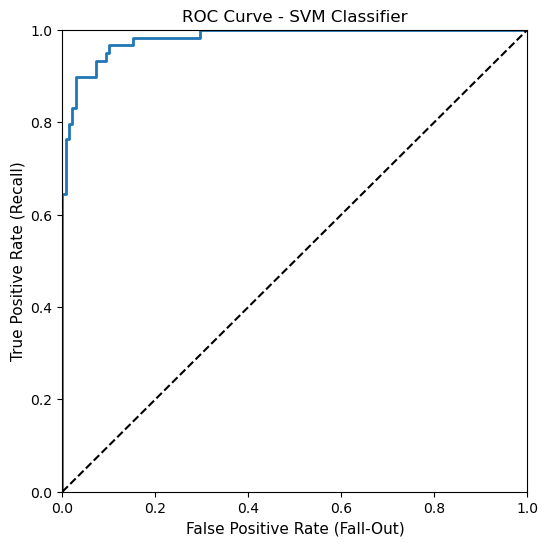

In [49]:
# Plotting ROC curve
svm_y_proba = best_svm_ovo.predict_proba(multi_test_x)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(multi_test_y, svm_y_proba[:, 1], pos_label=1)
auc_svm = auc(fpr_svm, tpr_svm)
print("AUC = {:.4f}".format(auc_svm))

plt.figure(figsize=(6,6))
plot_roc_curve(fpr_svm, tpr_svm)
plt.title("ROC Curve - SVM Classifier")
plt.grid(False)
plt.show()

From the above performance measures, we can observe：

(i) Confusion matrix: The confusion matrix of SVM Classifier looks reasonably accurate, since most of the instances are in the main diagonal, indicating they are classified correctly. As for the misclassification, we can see 'h' type instances are more likely to be misclassified than the other types. In total, there are 11 instances misclassified (10 of them are misclassified as 's' type and 1 is misclassidified as 'd' type).

(ii) Accuracy: The accuracy score of SVM Classifier (0.89) is high in the testing set, which means it can classified accurately in unseen data and there is no indication of underfitting. Moreover, as compared to the accuracy score in the training set, there is no overfitting since there is no significant drop noted when comparing the score in the testing set (0.89) to that of the training set (0.91).

(iii) Precision, recall and f1 score: All precision, recall and f1 score are high (0.89) for SVM Classifier, meaning it performs quite well.

(iv) ROC curve: The dotted line represents the ROC curve of a purely random classifier. The SVM Classifier ROC curve stays far away from the dotted line, towards the top-left corner and have AUC = 0.9821 (close to 1). These indicate the SVM Classifier performs well in the multiclass classification.

### 1.3.2 Softmax Regression

In [50]:
# Defining the softmax regression classifier
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Training the softmax regression classifier
softmax_reg.fit(multi_train_x, multi_train_y)

LogisticRegression(multi_class='multinomial')

In [51]:
# Making predictions on the test set
y_pred_softmax = softmax_reg.predict(multi_test_x)

print("Performance measures on Softmax Regression:\n")
performance_measure(softmax_reg)

Performance measures on Softmax Regression:

Confusion_matrix:

[[53  0  1  0]
 [ 0 56  1  2]
 [ 3  0 34  0]
 [ 0 10  0 38]]

Training set accuracy score: 0.9046
Testing set accuracy score: 0.9141


              precision    recall  f1-score   support

           0       0.95      0.98      0.96        54
           1       0.85      0.95      0.90        59
           2       0.94      0.92      0.93        37
           3       0.95      0.79      0.86        48

    accuracy                           0.91       198
   macro avg       0.92      0.91      0.91       198
weighted avg       0.92      0.91      0.91       198



AUC = 0.9887


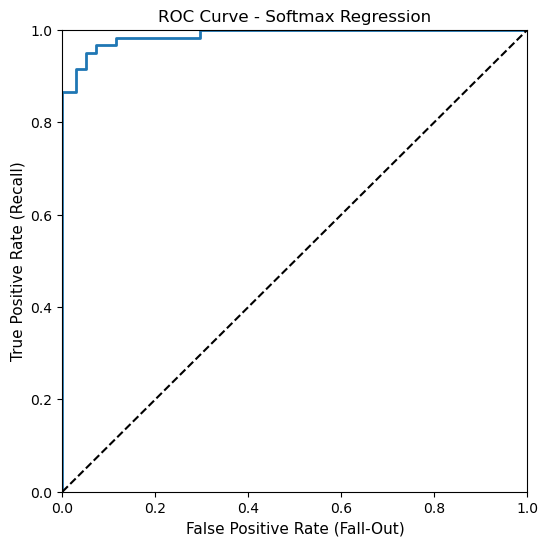

In [52]:
# Plotting ROC curve
softmax_y_proba = softmax_reg.predict_proba(multi_test_x)

fpr_softmax, tpr_softmax, thresholds_softmax = roc_curve(multi_test_y, softmax_y_proba[:, 1], pos_label=1)
auc_softmax = auc(fpr_softmax, tpr_softmax)
print("AUC = {:.4f}".format(auc_softmax))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_softmax, tpr_softmax)
plt.title("ROC Curve - Softmax Regression")
plt.grid(False)
plt.show()

From the above performance measures, we can observe：

(i) Confusion matrix: The confusion matrix of Softmax Regression looks reasonably accurate, since most of the instances are in the main diagonal, indicating they are classified correctly. As for the misclassification, we can see 'h' type instances are more likely to be misclassified than the other types. In total, there are 10 instances misclassified and all of them are misclassified as 's' type.

(ii) Accuracy: The accuracy score of Softmax Regression (0.91) is high in the testing set, which means it can classified accurately in unseen data and there is no indication of underfitting. Moreover, as compared to the accuracy score in the training set, there is no overfitting since the scores in the training and the testing set are similar.

(iii) Precision, recall and f1 score: All precision, recall and f1 score are high (0.91) for Softmax Regression, meaning it performs quite well.

(iv) ROC curve: The dotted line represents the ROC curve of a purely random classifier. The Softmax Regression ROC curve stays far away from the dotted line, towards the top-left corner and have AUC = 0.9887 (close to 1). These indicate the Softmax Regression performs well in the multiclass classification.

### 1.3.3 k-NN algorithm

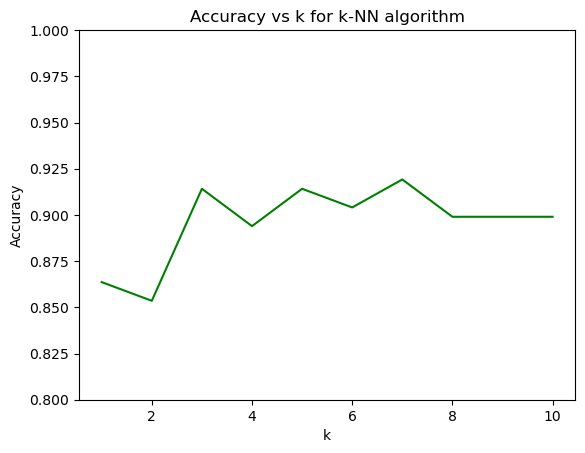

In [53]:
# Trying different k values
ks_multi = range(1,11)

# Training and computing accuracy score on k-NN for each k value
accuracies_knns_multi = []
for k in ks_multi:
    forest_knns = KNeighborsClassifier(n_neighbors=k)
    forest_knns.fit(multi_train_x, multi_train_y)
    knn_multi_y_pred = forest_knns.predict(multi_test_x)
    accuracies_knns_multi.append(accuracy_score(multi_test_y, knn_multi_y_pred))

# Plotting k vs accuracy
plt.plot(ks_multi, accuracies_knns_multi, color = 'green')
plt.ylim(0.8,1)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k for k-NN algorithm')
plt.grid(False)
plt.show()

From the above, we can see the accuracy fluctuates among different k values. The top 3 accuracy scores occur when k = 3, 5 and 7, while it reaches its peak at around 0.92 when k = 7.

When considering the optimal value of k, we not only have to focus on the performance, but also the complexity and processing time of the model training. Even though the accuracy score when k = 3 is slightly lower than that of k = 7, we will still select k = 3 in this project because it will give a relatively simple model requiring less processing time.

In [54]:
# Defining the k-NN classifier
k_multi = 3
knn_multi = KNeighborsClassifier(n_neighbors=k_multi)

# Training the k-NN classifier
knn_multi.fit(multi_train_x, multi_train_y)

KNeighborsClassifier(n_neighbors=3)

In [55]:
print("Performance measures on k-NN algorithm:\n")
performance_measure(knn_multi)

Performance measures on k-NN algorithm:

Confusion_matrix:

[[53  0  1  0]
 [ 1 56  0  2]
 [ 5  0 32  0]
 [ 0  8  0 40]]

Training set accuracy score: 0.9077
Testing set accuracy score: 0.9141


              precision    recall  f1-score   support

           0       0.90      0.98      0.94        54
           1       0.88      0.95      0.91        59
           2       0.97      0.86      0.91        37
           3       0.95      0.83      0.89        48

    accuracy                           0.91       198
   macro avg       0.92      0.91      0.91       198
weighted avg       0.92      0.91      0.91       198



AUC = 0.9713


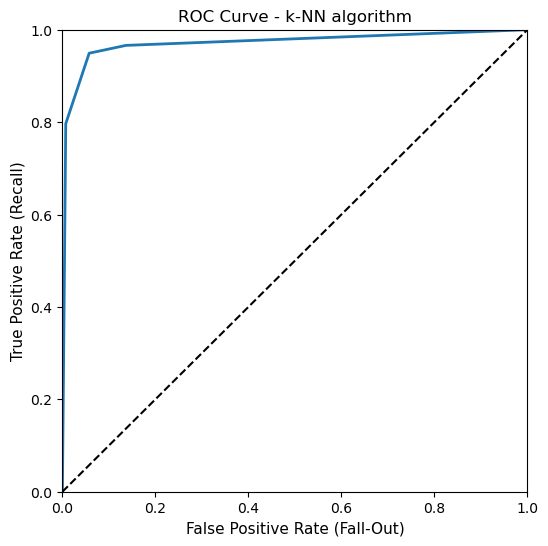

In [56]:
# Plotting ROC curve
knn_multi_y_proba = knn_multi.predict_proba(multi_test_x)

fpr_knn_multi, tpr_knn_multi, thresholds_knn_multi = roc_curve(multi_test_y, knn_multi_y_proba[:, 1], pos_label=1)
auc_knn_multi = auc(fpr_knn_multi, tpr_knn_multi)
print("AUC = {:.4f}".format(auc_knn_multi))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_knn_multi, tpr_knn_multi)
plt.title("ROC Curve - k-NN algorithm")
plt.grid(False)
plt.show()

From the above performance measures, we can observe：

(i) Confusion matrix: The confusion matrix of k-NN algorithm looks reasonably accurate, since most of the instances are in the main diagonal, indicating they are classified correctly. As for the misclassification, we can see 'h' type instances are more likely to be misclassified than the other types. In total, there are 8 instances misclassified and all of them are misclassified as 's' type. As compared to the previous 2 classifiers, k-NN algorithm seems to have fewer misclassification in "h" type.

(ii) Accuracy: The accuracy score of k-NN algorithm (0.91) is high in the testing set, which means it can classified accurately in unseen data and there is no indication of underfitting. Moreover, as compared to the accuracy score in the training set, there is no overfitting since the scores in the training and the testing set are similar.

(iii) Precision, recall and f1 score: All precision, recall and f1 score are high (0.91) for k-NN algorithm, meaning it performs quite well.

(iv) ROC curve: The dotted line represents the ROC curve of a purely random classifier. The k-NN algorithm ROC curve stays far away from the dotted line, towards the top-left corner and have AUC = 0.9713 (close to 1). These indicates the k-NN algorithm performs well in the multiclass classification.

### 1.3.4 SVM vs Softmax Regression vs k-NN algorithm

In [57]:
# Comparing accuracy scores
performance_measure(best_svm_ovo, accuracy = True, label = "SVM Classifier")
performance_measure(softmax_reg, accuracy = True, label = "Softmax Regression")
performance_measure(knn_multi, accuracy = True, label = "k-NN algorithm")

SVM Classifier Testing set accuracy score: 0.8889
Softmax Regression Testing set accuracy score: 0.9141
k-NN algorithm Testing set accuracy score: 0.9141


SVM Classifier AUC = 0.9827
Softmax Regression AUC = 0.9887
k_NN algorithm AUC = 0.9713


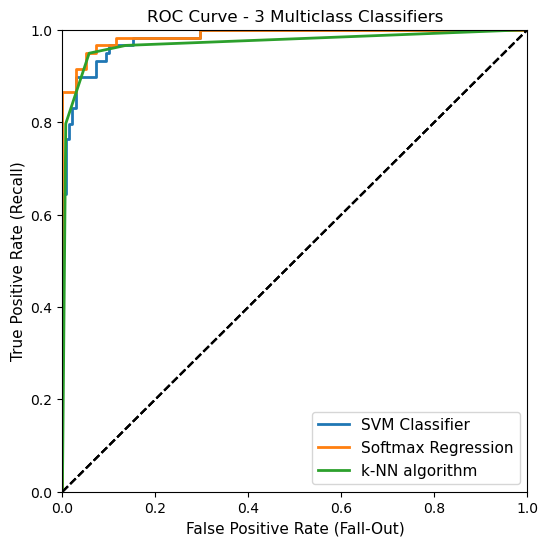

In [58]:
# Comparing AUC scores
print("SVM Classifier AUC = {:.4f}".format(auc_svm))
print("Softmax Regression AUC = {:.4f}".format(auc_softmax))
print("k_NN algorithm AUC = {:.4f}".format(auc_knn_multi))

# Plotting ROC Curve
plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_svm, tpr_svm, "SVM Classifier")
plot_roc_curve(fpr_softmax, tpr_softmax, "Softmax Regression")
plot_roc_curve(fpr_knn_multi, tpr_knn_multi, "k-NN algorithm")
plt.legend(loc="lower right", fontsize=11)
plt.title("ROC Curve - 3 Multiclass Classifiers")
plt.grid(False)
plt.show()

(i) Accuracy scores: Softmax Regression and k-NN algorithm (0.9141) get slightly higher scores than SVM Classifier (0.8889). However, all of them are considered to be high and indicate the classification performed by these classifiers are accurate.

(ii) AUC and ROC curves: Though all 3 classifiers have AUC close to 1, Softmax Regression has the largest AUC (0.9887) and highest ROC curve. 

To conclude, it is observed that Softmax Regression performs the best among these 3 classifiers based on the accuracy scores, AUC and ROC curve. Under the assignment scope, we are only required to perform multiclass classification in SVM Classifier, Softmax Regression and k-NN algorithm. However, there are more supervised machine learning alogrithms, such as Decision Trees and Naive Bayes, and may even outperform Softmax Regression. Hence, a possible next step would be including other algorithms and compare against their performance to Softmax Regression.

# Part 2 - Regression

In Part 2 of this assignment, the dataset analysed is modified from the California Housing Prices dataset from the StatLib repository. This dataset was based on data from the 1990 California census. This dataset is an example from the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" and can be obtained from https://github.com/ageron/handson-ml2.

The dataset contains information on the median house value in various neighborhoods in California, as well as information on other features such as the median income, the average number of rooms, and the population of each neighborhood.

In the following section, we aim to train a regression model by the k-nearest neighbours algorithm on the dataset to predict the housing prices.

## 2.1 Data loading, overview and set up

### 2.1.1 Loading the dataset in the Jupyter Notebook

In [59]:
housing = pd.read_csv("housing.csv")

### 2.1.2 Quick overview on the dataset

In [60]:
# Checking the dimensions of the overall dataset
print('Number of rows:', housing.shape[0])
print('Number of columns:', housing.shape[1])

housing.head(10)

Number of rows: 20640
Number of columns: 10


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [61]:
# Further look at the description of data using info()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [62]:
# Counting the number of instance in each class in the overall dataset
housing_label_counts = housing["ocean_proximity"].value_counts()
housing_label_proportions = housing_label_counts / len(housing)*100

housing_label_info = pd.DataFrame({'Count': housing_label_counts, 'Proportion': housing_label_proportions.map("{:.2f}%".format)})
print(housing_label_info)

            Count Proportion
<1H OCEAN    9136     44.26%
INLAND       6551     31.74%
NEAR OCEAN   2658     12.88%
NEAR BAY     2290     11.09%
ISLAND          5      0.02%


By looking at the dimension of the dataset, we can see that there are in total 20640 instances and 10 columns (median_house_value and 9 attributes).

From the above output, we can observe:

(i) types of variables

- 1 categorical variable : ocean_proximity;
- 9 numerical variables in the type of floating numbers: all remaining columns

(ii) missing values

There are 207 missing values noted in total_bedrooms (1% of the total population). We may have to consider if we have to remove these rows for our further analysis or impute with other estimates to ensure the completeness of data input for detailed data analysis afterwards in later stage.

(iii) variables may require transformation

There are certain attributes may not be useful to predict our target (median_house_value) by itself, such as total_rooms (total number of rooms in a district). We may have to transform them, such as combining with other attributes to form new useful variables.

(iv) variables providing similar information

There are some attributes provide similar information for predicting median_house_value, such as longitude, latitude and ocean_proximity. Since longitude and latitude are related to the location of the house, they already provide us with data on whether the house is located close to ocean or inland. Ocean_proximity provides similar information. We may consider to drop this attribute which not to make our regression model to be too complicated with similar attributes.

### 2.1.3 Data Visualisation

In [63]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


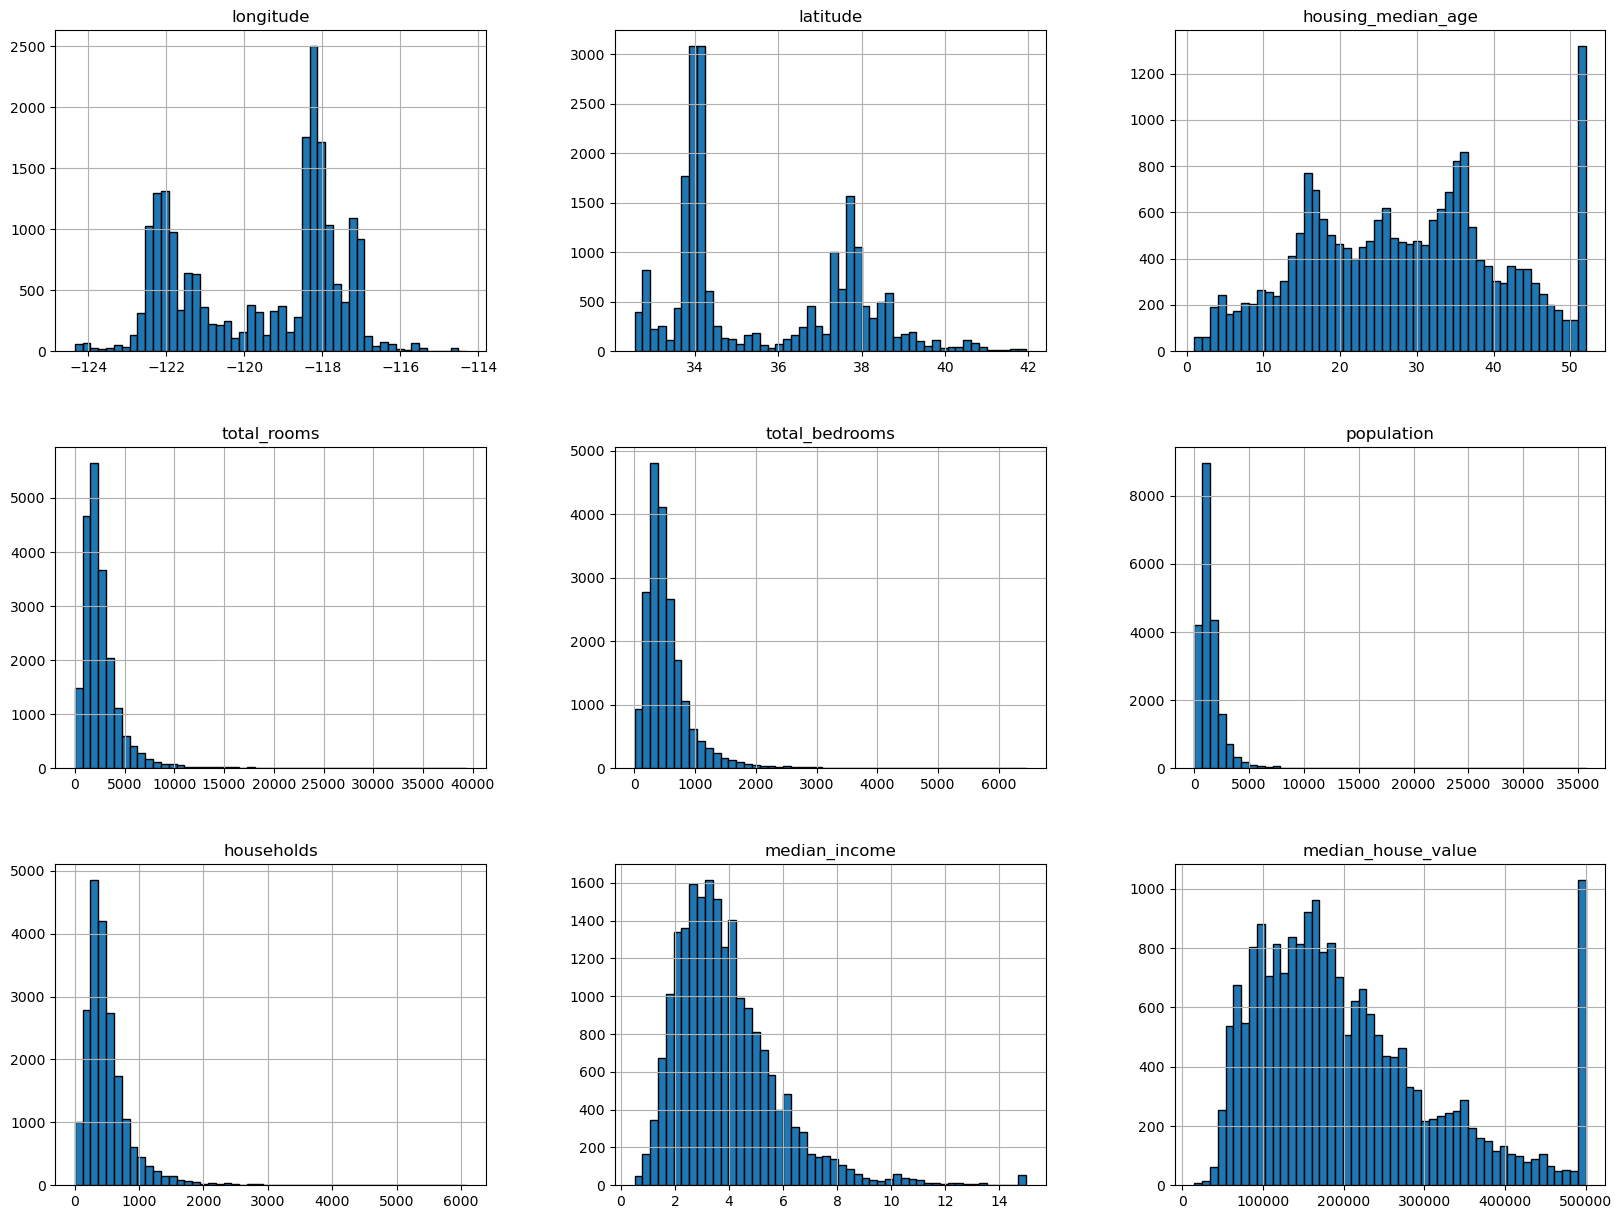

In [64]:
# Plotting histograms for every numberical variable
housing.hist(bins=50, figsize=(20,15),edgecolor = "black")
plt.show()

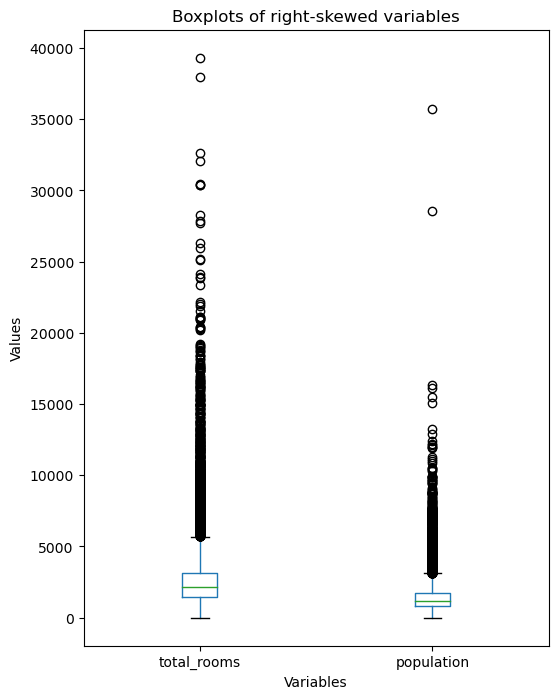

In [65]:
# Plotting histograms for right-skewed variables 
fig_housing_box, ax_housing_box = plt.subplots(figsize=(6, 8))
housing_cols1 = ["total_rooms", "population"]
housing[housing_cols1].boxplot(ax=ax_housing_box)

ax_housing_box.set_title("Boxplots of right-skewed variables")
ax_housing_box.set_xlabel("Variables")
ax_housing_box.set_ylabel("Values")
ax_housing_box.grid()
plt.show()

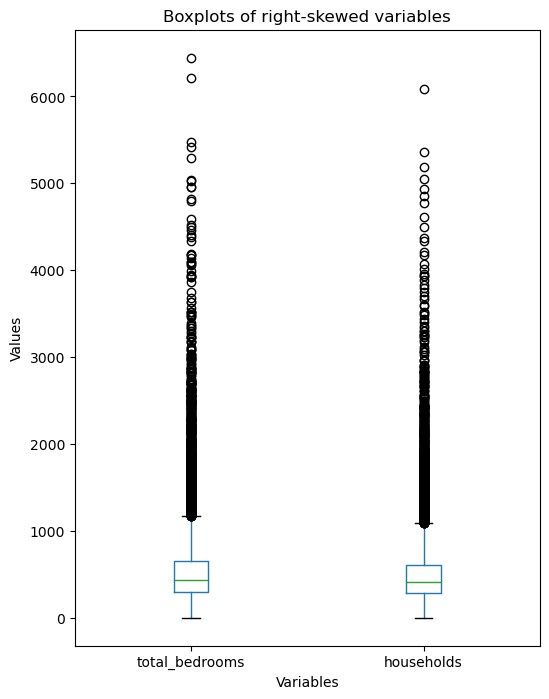

In [66]:
fig_housing_box2, ax_housing_box2 = plt.subplots(figsize=(6, 8))
housing_cols2 = ["total_bedrooms", "households"]
housing[housing_cols2].boxplot(ax=ax_housing_box2)

ax_housing_box2.set_title("Boxplots of right-skewed variables")
ax_housing_box2.set_xlabel("Variables")
ax_housing_box2.set_ylabel("Values")
ax_housing_box2.grid()
plt.show()

From the above histograms and boxplots, we can see they are consistent to the findings from the previous descriptive statistics table.

(i) Outliers: The distribution of some of the attributes (such as total_rooms, total_bedrooms, household and population) seem to be quite right-skewed in histograms, which indicate there are some outliers with very large values (also shown in the boxplots). Certain transformation may have to perform to make these attributions to be normally distributed for further analysis.

(ii) Different scales on the features: By looking at the x-axis in the histograms, there are different scales in the features. Since some of the machine learning algorithms are sensitive in scales of features, we will perform transformation to standardise their scales in later stage.

(iii) Range of values: There are some attributes capped with a ceiling, such as housing_median_age is capped in 50 years. We may have to further investigate on the coverage of these capped instances if we decide to include these attributes in our model.

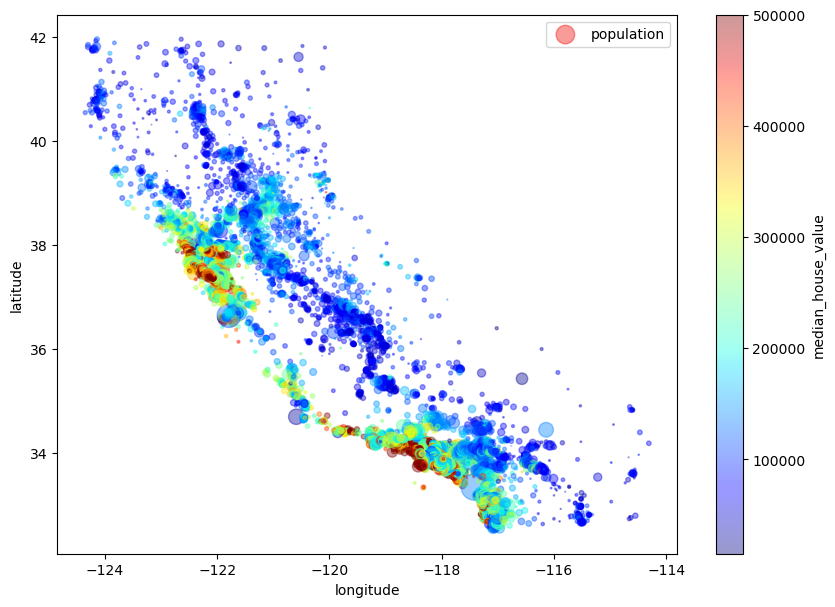

In [67]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

By looking at the above geographical visualisation, we can observe the areas with high density and higher median house values are around the Bay Area, Los Angeles, San Diego and the Central Valley.

By reviewing the dataset, we can see there are some attributes may not have meaningful message to predict the median housing value on its own, such as total number of rooms in a district. Thus, we experimented some new attributes by combining few attributes together.

In this case, we have created a new attribute "rooms per household" by dividing total_rooms by households. Since the number of rooms inside a house may have a more direct impact on the housing price.

In [68]:
# Experimenting with Attribute Combinations
housing_newattri = housing
housing_newattri["rooms_per_household"] = housing_newattri["total_rooms"] / housing_newattri["households"]

In [69]:
# Computing the correlations between attributes and target
corr_matrix = housing_newattri.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
population            -0.024650
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

From the above correlation table, we can see median_income has the strongest correlation (0.6881) with the target (median_house_value) among the remaining features. Moreover, we can see the correlation between the newly created attribute (rooms_per_household) and the target of 0.1519 is higher than that of total_rooms (0.1342), which suggests that rooms_per_household may be more powerful in predicting the target.

### 2.1.4 Data Cleaning

#### 2.1.4.1 Features selection

(i) Text variable

For the purpose of this assignment, we will focus on the numerical variables. Moreover, we believe from the attributes "longitde" and "latitude", we can obtain similar information on where the house locating. Thus, we will drop the text categorical variable "ocean_proximity" from our analysis.

(ii) Features with weak correlation with target (median_house_value)

From the above correlation table, we can observe that not all the features are having strong relationship with our target variable. We will drop all the variables which have correlation coefficients close to 0 (with difference smaller than 0.1), including households, total_bedrooms and population. Although the correlation of longitude is only -0.0460, we did not drop it as we believe it should be kept with latitude (which has a -0.1442 correlation) to provide a meaningful information on the location.

Besides, after dropping the total_bedrooms column, no missing value issue occurs in the dataset.

(iii) Features appear to be not useful in predicting median_house_value

Since total number of rooms in a district may not be useful to predict the median of housing values and a more meaningful attribute (total rooms per household) has been created. Therefore, we will remove total_rooms from the regression model training.

In [70]:
housing_clean = housing.drop(["ocean_proximity", "households", "total_bedrooms", 
                              "population", "total_rooms"], axis=1)

housing_clean.head(10)

,longitude,latitude,housing_median_age,median_income,median_house_value,rooms_per_household
0,-122.23,37.88,41.0,8.3252,452600.0,6.984127
1,-122.22,37.86,21.0,8.3014,358500.0,6.238137
2,-122.24,37.85,52.0,7.2574,352100.0,8.288136
3,-122.25,37.85,52.0,5.6431,341300.0,5.817352
4,-122.25,37.85,52.0,3.8462,342200.0,6.281853
5,-122.25,37.85,52.0,4.0368,269700.0,4.761658
6,-122.25,37.84,52.0,3.6591,299200.0,4.931907
7,-122.25,37.84,52.0,3.1200,241400.0,4.797527
8,-122.26,37.84,42.0,2.0804,226700.0,4.294118
9,-122.25,37.84,52.0,3.6912,261100.0,4.970588


In [71]:
# Double checking on the null values in the dataset
null_counts = housing_clean.isnull().sum()
null_counts

longitude              0
latitude               0
housing_median_age     0
median_income          0
median_house_value     0
rooms_per_household    0
dtype: int64

#### 2.1.4.2 Setting up a test set

In [72]:
# Randomly splitting the data into a training set (80%) and testing set (20%)
from sklearn.model_selection import train_test_split

housing_x = housing_clean.drop("median_house_value", axis = 1)
housing_y = housing_clean["median_house_value"].copy()

housing_train_x, housing_test_x, housing_train_y, housing_test_y = train_test_split(housing_x, housing_y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

#### 2.1.4.3 Feature scaling

In [73]:
# Scaling the features using standardisation to ensure all attributes have the same scales
scaler = StandardScaler()
housing_train_x_rescaled = scaler.fit_transform(housing_train_x)
housing_test_x_rescaled = scaler.transform(housing_test_x)

## 2.2 Regression (k-NN algorithm)

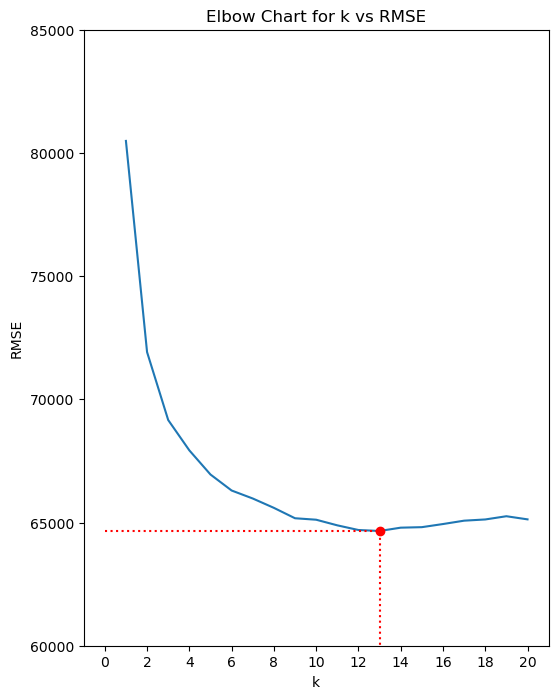

Best k value: 13
RMSE for best k: 64656.481075061565


In [74]:
from sklearn.neighbors import KNeighborsRegressor

# Defining the range of k values to test
k_values = range(1, 21)

# Loop over each k value and fit a k-NN regressor
best_k = 1
best_rmse = float('inf')
rmse_val = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    # Fitting the k-NN regression model
    knn.fit(housing_train_x_rescaled, housing_train_y)

    y_pred = knn.predict(housing_test_x_rescaled)
    
    # Calculating the RMSE
    rmse = np.sqrt(mean_squared_error(housing_test_y, y_pred))
    rmse_val.append(rmse)
    
    # Updating the best k value
    if rmse < best_rmse:
        best_k = k
        best_rmse = rmse

# Plotting the elbow chart for k vs RMSE
plt.figure(figsize=(6,8))
plt.plot(k_values, rmse_val)
plt.xticks(list(range(0, len(k_values)+1, 2)))
plt.ylim(60000,85000)
plt.plot([best_k, best_k], [0, best_rmse], "r:")
plt.plot([0, best_k], [best_rmse, best_rmse], "r:")
plt.plot([best_k], [best_rmse], "ro")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Elbow Chart for k vs RMSE')
plt.show()
    
print(f"Best k value: {best_k}")
print(f"RMSE for best k: {best_rmse}")

From the above, we can see RMSE is the lowest (64656) when k = 13 and the RMSE increases afterwards, indicating k=13 is the optimal k to train the k-NN regression model. We then used k = 13 for our k-NN regression model.

### 2.2.1 Training a k-NN regression model (weights = 'uniform')

In [75]:
# Training an uniform weighted k-NN regression model with k = 13
housing_knn_uni = KNeighborsRegressor(n_neighbors=13, weights='uniform')
housing_knn_uni.fit(housing_train_x_rescaled, housing_train_y)

KNeighborsRegressor(n_neighbors=13)

In [76]:
from sklearn.metrics import make_scorer

# Function to compute RMSE in (i)Training set, (ii) 5-fold cross validation and (iii) Testing set
def RMSE_summary(model, dataset, test_only = False, label = None):
    
    train_x = eval(dataset + "_train_x_rescaled")
    train_y = eval(dataset + "_train_y")
    test_x = eval(dataset + "_test_x_rescaled")
    test_y = eval(dataset + "_test_y")
    
    if test_only == False:
        # Computing RMSE in training set
        train_y_pred = model.predict(train_x)
        rmse_train = np.sqrt(mean_squared_error(train_y, train_y_pred))
        print("Training RMSE: {:.4f}".format(rmse_train))

        # Performing 5-fold cross-validation and get the RMSE scores for each fold
        scoring = make_scorer(mean_squared_error, squared=False)
        cv_scores = cross_val_score(model, train_x, train_y, cv=5, scoring=scoring)

        # Function to present (i)RMSE for every fold, (ii) mean RMSE and (iii) RMSE standard deviation
        def display_RMSE(RMSE):
            print("RMSE:")
            for i, score in enumerate(RMSE):
                print("Fold {}: {:.4f}".format(i+1, score))
            print("Mean RMSE: {:.4f}".format(RMSE.mean()))
            print("Standard deviation of RMSE: {:.4f}".format(RMSE.std()))

        print("\n5-fold cross-validation:\n")
        display_RMSE(cv_scores)

        # Computing RMSE in testing set
        test_y_pred = model.predict(test_x)
        rmse_test = np.sqrt(mean_squared_error(test_y, test_y_pred))
        print("\nTesting RMSE: {:.4f}".format(rmse_test))

    else: 
        # Computing RMSE in testing set
        test_y_pred = model.predict(test_x)
        rmse_test = np.sqrt(mean_squared_error(test_y, test_y_pred))
        print(label, "Testing RMSE: {:.4f}".format(rmse_test))
    
print("Uniform weighted K-NN Regression model:\n")
RMSE_summary(housing_knn_uni, dataset = "housing")

Uniform weighted K-NN Regression model:

Training RMSE: 59454.2026

5-fold cross-validation:

RMSE:
Fold 1: 65820.5165
Fold 2: 63428.6826
Fold 3: 65995.0194
Fold 4: 64504.9028
Fold 5: 65160.1964
Mean RMSE: 64981.8636
Standard deviation of RMSE: 938.2418

Testing RMSE: 64656.4811


From the above, we can see the training RMSE (59454) is lower than 5-fold cross validation mean RMSE (64982) and Testing RMSE (64656). This indicates the model performs better in the trained data and its performance deteriorates in unseen data. Though the difference is not so significant, this may indicate there may be overfitting in the model. To confirm if there are overfitting in the model, we could further experiment to simplify the model by dropping more features. We will experiment to drop 1 more feature in section 2.2.3 and to compare the performance.

### 2.2.2 Training a k-NN regression model (weights = 'distance')

In this section, we will reperform a k-NN regression model by changing one of the hyperparameters from weights = 'uniform' to weights = 'distance'. For better comparison on the performance, we used k = 13 (consistent to previous k-NN regressor) in training a distance weighted k-NN Regression model.

In [77]:
# Training a distance weighted k-NN regression model with k = 13
housing_knn_dis = KNeighborsRegressor(n_neighbors=13, weights = 'distance')
housing_knn_dis.fit(housing_train_x_rescaled, housing_train_y)

KNeighborsRegressor(n_neighbors=13, weights='distance')

In [78]:
print("Distance weighted K-NN Regression model:\n")
RMSE_summary(housing_knn_dis, dataset = "housing")

Distance weighted K-NN Regression model:

Training RMSE: 0.0000

5-fold cross-validation:

RMSE:
Fold 1: 65127.2120
Fold 2: 62789.9623
Fold 3: 65555.8501
Fold 4: 63625.1794
Fold 5: 64538.0135
Mean RMSE: 64327.2434
Standard deviation of RMSE: 1004.9851

Testing RMSE: 64080.7977


From the above, we can see the training RMSE is 0 for distance weighted k-NN Regression model. The reason for this is the model predicts the exact values of the training data by the distance weighting methodology. However, this may not necessarily mean the model is overfitting, we can further evaluate its performance on cross validation and testing set.

When comparing the performance between 5-fold cross validation and testing set, we can observe the model's testing RMSE (64081) is similar to its mean RMSE in 5-fold cross validation (64327), which suggests the distance weighted k-NN regressor performs reasonably well in unseen data and may not be overfitting. However, we can also do more analysis (such as dropping more features from the model to determine any overfitting in the model) in section 2.2.3.

In [79]:
RMSE_summary(housing_knn_uni, dataset = "housing",
             test_only = True, label = "Uniform weighted k-NN Regression model")
RMSE_summary(housing_knn_dis, dataset = "housing", 
             test_only = True, label = "Distance weighted k-NN Regression model")

Uniform weighted k-NN Regression model Testing RMSE: 64656.4811
Distance weighted k-NN Regression model Testing RMSE: 64080.7977


As compared with two k-NN regression models, we can observed the RMSE on distance weighted k-NN regression model (64081) is slightly lower than that of uniform weighted k-NN regression model (64656). Since a lower RMSE indicates better performance, distance weighted k-NN regression model outperforms the uniform weighted k-NN regression model in this case.

### 2.2.3 Further analysis on the k-NN Regression models

From the previous section, we have noted that the RMSE of testing set and 5-fold cross validation are relatively lower than the training RMSE for uniform weighted k-NN regression model, which may suggest there is overfitting issue. While for distance weighted k-NN regression model, it may worth more analysis on checking the model's generalisation given the training RMSE is 0. 

Thus, we tried to drop more features to simplify our model and to compare the performance on generalisation. In this case, we dropped housing_median_age from the model since it has weak correlation with the target (median_house_value) as compared to the remaining features (as shown in the correlation table in section 2.1.3 and the following chart).

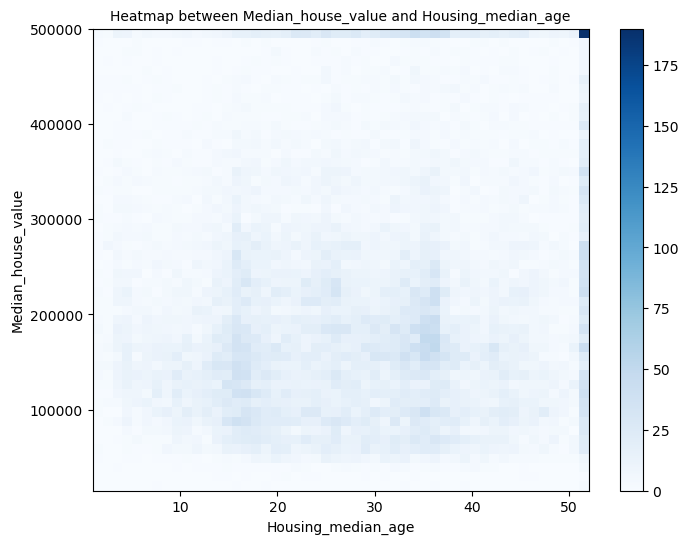

In [80]:
median_house_value = housing['median_house_value']
housing_median_age = housing['housing_median_age']

# Plotting the heatmap between median_house_value and housing_median_age
plt.figure(figsize=(8,6))
plt.hist2d(housing_median_age, median_house_value, bins=(50, 50), cmap='Blues')
plt.xlabel('Housing_median_age')
plt.ylabel('Median_house_value')
plt.title("Heatmap between Median_house_value and Housing_median_age", fontsize=10)
plt.colorbar()
plt.show()

In [81]:
# Removing housing_median_age from the dataset
housing_new = housing_clean
housing_new = housing_new.drop(["housing_median_age"], axis=1)
housing_new_x = housing_new.drop("median_house_value", axis = 1)
housing_new_y = housing_new["median_house_value"].copy()

housing_new_train_x, housing_new_test_x, housing_new_train_y, housing_new_test_y = train_test_split(housing_new_x, housing_new_y, test_size=0.2, random_state=42)

housing_new_train_x_rescaled = scaler.fit_transform(housing_new_train_x)
housing_new_test_x_rescaled = scaler.transform(housing_new_test_x)

In [82]:
# Training a k-NN regression model (weights = 'uniform') with k = 13
housing_new_knn_uni = KNeighborsRegressor(n_neighbors=13, weights='uniform')
housing_new_knn_uni.fit(housing_new_train_x_rescaled, housing_new_train_y)

KNeighborsRegressor(n_neighbors=13)

In [83]:
print("Uniform weighted K-NN Regressor:\n")
RMSE_summary(housing_new_knn_uni, dataset = "housing_new")

Uniform weighted K-NN Regressor:

Training RMSE: 57216.7933

5-fold cross-validation:

RMSE:
Fold 1: 63111.8544
Fold 2: 61402.1277
Fold 3: 63556.0288
Fold 4: 61627.5273
Fold 5: 63589.1435
Mean RMSE: 62657.3364
Standard deviation of RMSE: 950.6371

Testing RMSE: 63062.1312


From the above, we can see all the Training RMSE, 5-fold cross validation mean RMSE and Testing RMSE are lower after removing the feature housing_median_age. This indicates the model performs better now. As for the generalisation of the model, since the difference between training RMSE and the other two (around 5000) is similar to the previous model. It suggests that the the uniform weighted k-NN regression model is unlikely to be overfit.

In [84]:
# Training a k-NN regression model (weights = 'distance') with k = 13
housing_new_knn_dis = KNeighborsRegressor(n_neighbors=13, weights = 'distance')
housing_new_knn_dis.fit(housing_new_train_x_rescaled, housing_new_train_y)

KNeighborsRegressor(n_neighbors=13, weights='distance')

In [85]:
print("Distance weighted K-NN Regressor:\n")
RMSE_summary(housing_new_knn_dis, dataset = "housing_new")

Distance weighted K-NN Regressor:

Training RMSE: 0.0000

5-fold cross-validation:

RMSE:
Fold 1: 61871.6032
Fold 2: 60385.8635
Fold 3: 62527.0860
Fold 4: 60619.1824
Fold 5: 62646.5473
Mean RMSE: 61610.0565
Standard deviation of RMSE: 944.8961

Testing RMSE: 62011.4606


As for the distance weighted k-NN regression model, both 5-fold cross validation RMSE and testing RMSE has slightly improved as compared to the one in section 2.2.2. Since the differences between 5-fold cross validation RMSE and testing RMSE are similar for this model and that in section 2.2.2, it is unlikely the distance weighted k-NN regression model is overfitted.

Moreover, same as section 2.2.2, the distance weighted k-NN regression model performs slightly better than uniform weighted k-NN regression model with lower testing RMSE.

## 2.3 Conclusion

In conclusion, distance weighted k-NN regression model, which has features "longitude", "latitude", "median_income", "rooms_per_household", performs the best with lowest testing RMSE among all the k-NN regression models we trained in this part. Under the assignment scope, we are only required to perform k-NN alogorithm and compare RMSE on the performance. However, there are more performance measures and more supervised machine learning algorithms, such as Linear Regression model and Random Forests Regressor and may even outperform k-NN Regression model. Hence, a possible next step would be including other algorithms and compare against their performance to k-NN Regression model with more performance measures.